# Introduction

The Coastal Marine Zones dataset used in this notebook can be found <a href="https://www.weather.gov/gis/MarineZones">here.</a>

<b>What is a "Marine Zone Forecast"?</b>

National Weather Service marine zones are specific, defined over-water areas contained in the various NWS marine forecast products. Each zone is identified by a text description and a Universal Generic Code (UGC), e.g. LONG ISLAND SOUND EAST OF NEW HAVEN CT/PORT JEFFERSON NY, ANZ330. Zones are divided to identify meteorlogically dissimilar areas. Marine Zone Forecasts outline the range of conditions which may be found within the entire zone. The size of a zone and the number of zones within a forecast product is a compromise between forecast accuracy and dissemination limitations.

The <b>marine environment</b> is defined as those waters that are saline and tide-affected.   The <b>coastal zone</b> is defined as those areas of land which border the marine environment.  The coastal zone extends inland to the first major change in topography beyond which coastal processes have little influence).

<b>Examples of coastal ecosystems:</b> Estuaries, coastal dunes, rocky coasts, sandy beaches, coastal cliffs, intertidal (littoral) areas.<br>
<b>Examples of marine ecosystems:</b> Coral reefs, benthic, kelp forests, rocky reefs, continental shelves, sea-mounts, hydro-thermal vents, open oceans, polar oceans.<br>
<b>Oceanic zones:</b> Epipelagic, mesopelagic, bathypelagic, abyssalpelagic, hadalpelagic.<br>
<b>Coastal zones:</b> Inshore, littoral, foreshore, backshore.<br>

From description about <a href="http://www.tulane.edu/~sanelson/Natural_Disasters/coastalzones.htm">Coastal zones</a>. A coastal zone is the interface between the land and water. These zones are important because a majority of the world's population inhabit such zones. Coastal zones are continually changing because of the dynamic interaction between the oceans and the land. Waves and winds along the coast are both eroding rock and depositing sediment on a continuous basis, and rates of erosion and deposition vary considerably from day to day along such zones. The energy reaching the coast can become high during storms, and such high energies make coastal zones areas of high vulnerability to natural hazards.  Thus, an understanding of the interactions of the oceans and the land is essential in understanding the hazards associated with coastal zones.  Tides, currents, and waves bring energy to the coast, and thus we start with these three factors. 


<b>Abstract:</b>

Coastal marine forecasts and Special Marine Warnings are issued by zone, each zone identified by a text description and a Universal Generic Code (UGC). These forecasts are prepared by the individual Weather Forecast Office responsible for the zone.

<b>Purpose:</b>

To deliniate the coastal marine zones for the use in creating coastal marine forecasts and warnings.

## Programming
GeoPandas

GeoPandas is an open source project to make working with geospatial data in python easier. GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. Geometric operations are performed by shapely. Geopandas further depends on fiona for file access and descartes and matplotlib for plotting.

The goal of GeoPandas is to make working with geospatial data in python easier. It combines the capabilities of pandas and shapely, providing geospatial operations in pandas and a high-level interface to multiple geometries to shapely. GeoPandas enables you to easily do operations in python that would otherwise require a spatial database such as PostGIS.

OGC SimpleFeatures

A standard that specifies a common storage and access model of mostly two-dimensional geographical data (point, line, polygon, multi-point, multi-line, etc.) The formats were originally defined by the Open Geospatial Consortium (OGC) and described in their Simple Feature Access and Coordinate Transformation Service specifications.

The standard defines a model for two-dimensional simple features, with linear interpolation between vertices. The data model defined is a hierarchy of classes. This part also defines representation using Well-Known Text (and Binary).
WKT/WKB: Well Known Text and Well Known Binary

Well-known text (WKT) is a text markup language for representing vector geometry objects on a map, spatial reference systems of spatial objects and transformations between spatial reference systems. A binary equivalent, known as well-known binary (WKB), is used to transfer and store the same information on databases, such as PostGIS, Microsoft SQL Server and DB2. The formats were originally defined by the Open Geospatial Consortium (OGC) and described in their Simple Feature Access and Coordinate Transformation Service specifications.
Implications for PySpark data de/serialization & un/marshalling

When using pyspark we want have to send data back and forth between master node and the workers which run jobs on the JVM. In order to simplify this rather than sending Python or more precisely Shapely objects we will use WKT. It works with one the libraries I am using today to perform Spatial Joins.

<b>References :<b>
- <a href="http://www.nws.noaa.gov/om/marine/faq.htm#28">What is a "Marine Zone Forecast"?</a>
- <a href="http://www.tulane.edu/~sanelson/Natural_Disasters/coastalzones.htm">Coastal zones By Prof. Stephen A. Nelson</a>

<b>Overview of Coastal, Offshore and High Seas Marine Zones</b>

<b>Date dataset :</b> june, 16th 2018<br>
<b>Shapefile Type:</b> Polygon<br>
<b>Data source:</b> Coastline derived from US Counties<br>
<b>Naming convention:</b> mzddmmyy (coastal marine zones), ozddmmyy (offshore zones), hzddmmyy (high seas zones)  where ddmmyy = day-month-year<br>

<b>NWS Specifications:</b> NWSI 10-302<br>
<b>Description:</b> The NWS issues marine forecasts, watches, warnings and advisories for a set of defined zone for offshore and coastal waters of the U.S.

In [1]:
#import package python libraries
import os.path, json, io
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (32, 40)

import pyspark.sql.functions as func # resuse as func.coalace for example
from pyspark.sql.types import StringType, IntegerType, FloatType, DoubleType,DecimalType
from pyspark.sql import SparkSession

import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame # Loading boundaries Data
from shapely.geometry import Point, Polygon, shape # creating geospatial data
from shapely import wkb, wkt # creating and parsing geospatial data
from ast import literal_eval as make_tuple # used to decode data from java

In [2]:
# Create SparkSession and attach Sparkcontext to it
spark = SparkSession.builder.appName("coastal-marine-zones-spatial-database").getOrCreate()
sc = spark.sparkContext

## 1. Load Coastal Marine Zones Data

<b>Description : </b>Coastal Marine Zones Including the Great Lakes

Coastal and Great Lakes forecasts are subdivided by zone, each identified by text description and a Universal Generic Code (UGC). The entire text of these forecasts may be found at <a href="http://www.nws.noaa.gov/om/marine/forecast.htm">NWS Marine Text Forecasts and Products Listing</a> which also serves as an alternate source of data. These forecasts are produced by <a href="http://www.nws.noaa.gov/om/marine/marine_map.htm">local National Weather Service Forecast Offices</a>. This page is also available in a text version which includes a synopsis for most of these areas. 
    

In [3]:
#list of dataset
!ls /home/tri/Spark/dataset/mz05de17/

mz05de17.cpg  mz05de17.dbf  mz05de17.prj  mz05de17.shp	mz05de17.shx


In [4]:
# Load the Coastal Marine Zones Including the Great Lakes
mz_df = GeoDataFrame.from_file('/home/tri/Spark/dataset/mz05de17/')

In [5]:
#attribute columns of dataset
mz_df.columns

Index([u'ID', u'WFO', u'GL_WFO', u'NAME', u'LON', u'LAT', u'geometry'], dtype='object')

In [6]:
#get information about shapefiles from dataset
mz_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
ID          500 non-null object
WFO         500 non-null object
GL_WFO      133 non-null object
NAME        500 non-null object
LON         500 non-null float64
LAT         500 non-null float64
geometry    500 non-null object
dtypes: float64(2), object(5)
memory usage: 27.4+ KB


In [7]:
#show 5 head of dataset
mz_df.head()

ID  WFO GL_WFO                                               NAME  \
0  PHZ113  HFO   None                                      Kauai Channel   
1  PHZ112  HFO   None                               Kauai Leeward Waters   
2  GMZ155  BRO   None  Coastal waters from Baffin Bay to Port Mansfie...   
3  GMZ657  MFL   None  Coastal waters from East Cape Sable to Chokolo...   
4  GMZ656  MFL   None  Coastal waters from Chokoloskee to Bonita Beac...   

          LON        LAT                                           geometry  
0 -158.972420  21.616939  POLYGON ((-158.745995314 22.08591056400007, -1...  
1 -160.231390  21.664122  POLYGON ((-159.62633932 22.19913730500002, -15...  
2  -97.157908  26.906845  POLYGON ((-96.88227653499996 26.59007835400007...  
3  -81.389492  25.453694  POLYGON ((-81.34737199999995 25.82093900000007...  
4  -81.872501  25.953719  (POLYGON ((-81.35332512199994 25.8227071780000...

Detailed Description of the columns:
- ID: Identifier of zone
- WFO: Identifier of organization responsible for forecast to the zone
- GL_WFO: Great lakes WFO responsible for Open Lake Forecastts
- NAME: Name of zone
- LON: Longitude of centroid zone [decimal degrees]
- LAT: Latitude of centroid of zone [decimal degrees]

In [8]:
# * find out the Spatial Reference System (CRS/SRS) for the GeoDataframe?
# A note about CRS's and Geospatial Data.
mz_df.crs

{'init': u'epsg:4269'}

<b>CRS</b> is the geometric shapes in a geoseries or geodataframe onject are simply a collection of coordinates in a arbitary space.
<b>CRS</b> are referred to using codes called proj4 strings. You can find the codes for most commonly used projections from www.spatialreference.org or remotesensing.org. see : http://geopandas.org/projections.html

In [9]:
# * plot the geometries?
mz_df.plot(figsize=(16,8))

In [10]:
#print out the wkt versiont of the geometries
wkts = map(lambda g: g.to_wkt(), mz_df.geometry)
wkts[0]
type(mz_df.geometry)

geopandas.geoseries.GeoSeries

### Spatial manipulations

In addition to operations purely based on values of the table, as above, GeoDataFrames come built-in with a whole range of traditional GIS operations. Here we will run through a small subset of them that contains some of the most commonly used ones.

- Centroid calculation

Sometimes it is useful to summarize a polygon into a single point and, for that, a good candidate is its centroid (almost like a spatial analogue of the average). The following command will return a GeoSeries (a single column with spatial data) with the centroids of a polygon GeoDataFrame:


In [11]:
cents = mz_df.centroid
cents.head()

0    POINT (-158.9724196326189 21.61693893242441)
1    POINT (-160.2313903386068 21.66412201886617)
2    POINT (-97.15790768346869 26.90684523917795)
3    POINT (-81.38949155095996 25.45369426599558)
4    POINT (-81.87250114898133 25.95371919321479)
dtype: object

Note how cents is not an entire table but a single column, or a GeoSeries object. This means you can plot it directly, just like a table:

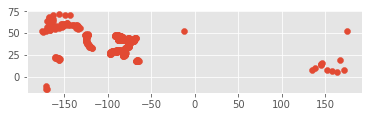

In [12]:
cents.plot()

## 2. Load Offshore Marine Zones data
<b> Description: Offshore Marine Zones</b>

OFFSHORE WATERS forecasts are subdivided by zone, each identified by text description and a Universal Generic Code (UGC).

These forecasts are prepared by the <a href="https://ocean.weather.gov/">Ocean Prediction Center</a>, <a href="http://www.nhc.noaa.gov/">National Hurricane Center</a>, <a href="http://www.prh.noaa.gov/hnl/">Honolulu Forecast Office</a>, <a href="http://www.weather.gov/ajk/">Juneau Forecast Office</a>, <a href="http://www.weather.gov/afc/">Anchorage Forecast Office</a>, and <a href="http://www.weather.gov/afg/">Fairbanks Forecast Office</a>. 

In [13]:
#list the dataset
!ls /home/tri/Spark/dataset/oz01ap14/

oz01ap14.dbf  oz01ap14.prj  oz01ap14.shp  oz01ap14.shx


In [14]:
#load offshore marine zonesdataset 
oz_df = GeoDataFrame.from_file('/home/tri/Spark/dataset/oz01ap14/')


In [15]:
#show head from dataset
oz_df.head()

ID  WFO       LON       LAT  \
0  AMZ031  NH2 -79.34953  11.83763   
1  AMZ013  NH2 -81.74130  18.75795   
2  AMZ037  NH2 -59.99007  14.44086   
3  AMZ121  NH2 -72.99113  24.81218   
4  AMZ011  NH2 -81.74130  18.75795   

                                            LOCATION  \
0                       from 11N-15N between 72W-80W   
1                       north of 18N between 76W-85W   
2                        from 7N-15N between 55W-60W   
3                       from 22N-27N between 65W-70W   
4  from 18N-22N west of 85W to Yucatan Peninsula ...   

                                                NAME  \
0  Caribbean from 11N to 15N between 72W and 80W ...   
1  Caribbean N of 18N between 76W and 85W includi...   
2  Tropical N Atlantic from 7N and 15N between 55...   
3       Atlantic from 22N to 27N between 65W and 70W   
4  Caribbean Nof 18N W of 85W including Yucatan B...   

                                            geometry  
0  POLYGON ((-72.00606649499997 15.03032157200005...  
1  POLYGON ((-82.34419558999997 22.48400648500007...  
2  POLYGON ((-54.98014895199998 15.00294936700004...  
3  POLYGON ((-64.99909230599997 22.00331475900003...  
4  POLYGON ((-85.00351240299995 21.65418662700006...

Detailed Description of the columns:
- ID: Identifier of zone
- WFO: Identifier of organization responsible for forecast to the zone
- LON: Longitude of centroid zone [decimal degrees]
- LAT: Latitude of centroid of zone [decimal degrees]
- LOCATION: Location of zone
- NAME: Name of zone

In [16]:
# * find out the Spatial Reference System (CRS/SRS) for the GeoDataframe?
# A note about CRS's and Geospatial Data.
oz_df.crs

{'init': u'epsg:4269'}

In [17]:
cents = oz_df.centroid
cents.head()

0    POINT (-76.20842221388843 13.11783970052544)
1    POINT (-81.12722939895168 19.77971176006738)
2    POINT (-57.40995459052026 11.13530316095404)
3    POINT (-67.50394358729233 24.50399712040652)
4    POINT (-86.08280616483469 19.86819710388435)
dtype: object

In [18]:
cents.plot(figsize=(16,8))

In [19]:
#plot the geometries and show legend from WFO "Weather Forecast Office"
oz_df.plot(column='WFO', categorical=True, legend=True, figsize=(16, 8))
plt.show()

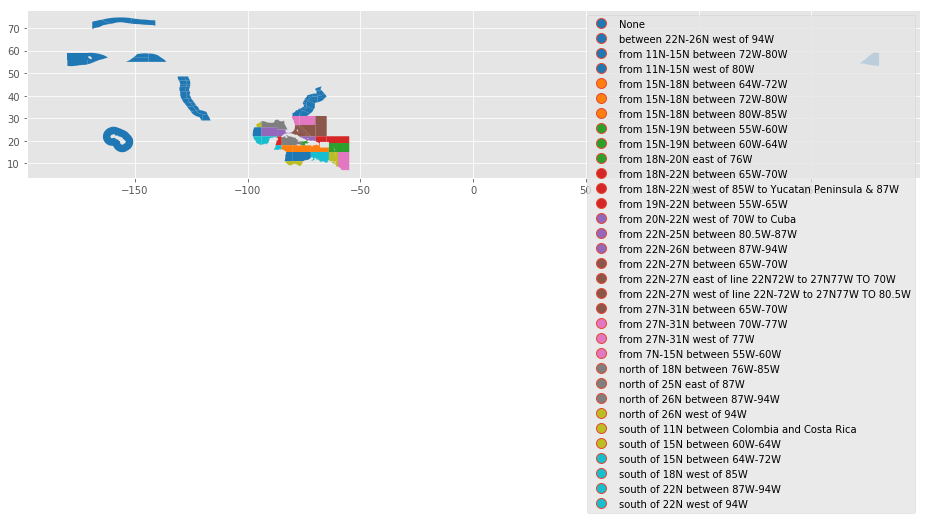

In [20]:
#plot the geometries and show legend from WFO "Weather Forecast Office"
oz_df.plot(column='LOCATION', categorical=True, legend=True, figsize=(16, 8))
plt.show()


## 3. Load "Natural Earth" countries dataset, bundled with GeoPandas

"Natural Earth is a public domain map dataset available at 1:10m, 1:50m, and 1:110 million scales. Featuring tightly integrated vector and raster data, with Natural Earth you can make a variety of visually pleasing, well-crafted maps with cartography or GIS software." It (a subset?) comes bundled with GeoPandas and is accessible from the gpd.datasets module. We'll use it as a helpful global base layer map.


In [21]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

pop_est      continent                  name iso_a3  gdp_md_est  \
0  28400000.0           Asia           Afghanistan    AFG     22270.0   
1  12799293.0         Africa                Angola    AGO    110300.0   
2   3639453.0         Europe               Albania    ALB     21810.0   
3   4798491.0           Asia  United Arab Emirates    ARE    184300.0   
4  40913584.0  South America             Argentina    ARG    573900.0   

                                            geometry  
0  POLYGON ((61.21081709172574 35.65007233330923,...  
1  (POLYGON ((16.32652835456705 -5.87747039146621...  
2  POLYGON ((20.59024743010491 41.85540416113361,...  
3  POLYGON ((51.57951867046327 24.24549713795111,...  
4  (POLYGON ((-65.50000000000003 -55.199999999999...

In [22]:
#show the CRS from world map
world.crs

{'init': u'epsg:4326'}

In [23]:
#plot world the geometries
world.plot(figsize=(16,8))
plt.show()

## 4. Map plot overlays: Plotting multiple spatial layers

Here's a compact, quick way of Using GeoDataFrame plot method to overlay two GeoDataFrame. In this case we are overlaying the world and the Offshore Marine Zones.


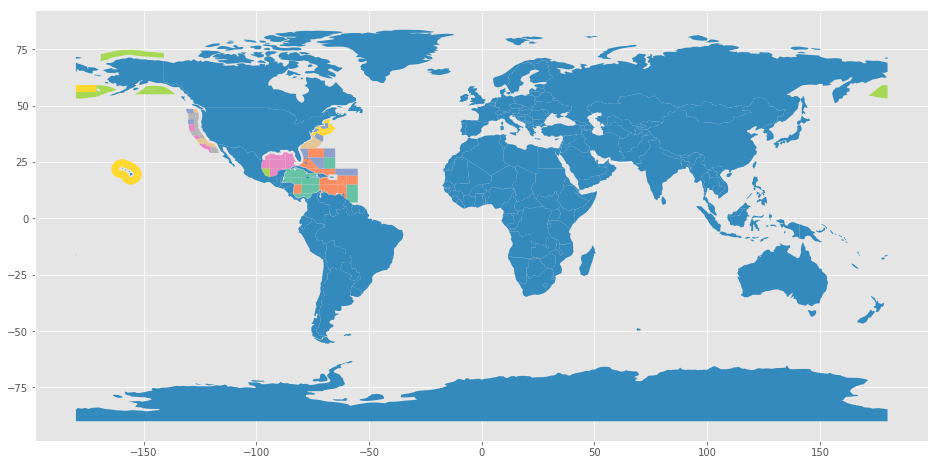

In [24]:
world.plot(ax=oz_df.plot(cmap='Set2', alpha=1, figsize=(16, 8)), alpha=1)
plt.show()

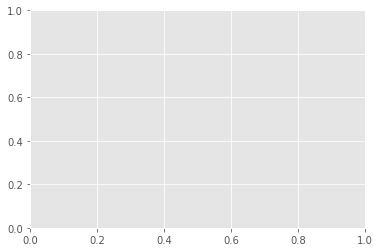

In [25]:
fig, ax = plt.subplots()

In [26]:
# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.
ax.set_aspect('equal')
ax.legend(loc='lower center')

In [27]:
world.plot(ax=ax)
oz_df.plot(ax=ax)
mz_df.plot(ax=ax)
plt.show();

<Figure size 432x288 with 0 Axes>

## 5. Preparing Data for PySpark

The following cells will introduce some of the aggregation functions available to us in Spark SQL.

Spark expects a geospatial column as a WKT string. Internally it uses this to create OGC Geometries via Java Topology Suite (JTS). So in order to use Spatial Spark we will add the WKT column to our data.


In [28]:
#procedure how to change spark dataframe from world dataset
world['wkt'] = pd.Series(
                map(lambda geom: str(geom.to_wkt()), world['geometry']),
                index=world.index, dtype='string')

In [29]:
#procedure how to change spark dataframe from offshore zone dataset
oz_df['wkt'] = pd.Series(
                map(lambda geom: str(geom.to_wkt()), oz_df['geometry']),
                index=oz_df.index, dtype='string')
#procedure how to change spark dataframe from marine zone dataset
mz_df['wkt'] = pd.Series(
                map(lambda geom: str(geom.to_wkt()), mz_df['geometry']),
                index=mz_df.index, dtype='string')

In [30]:
# drop the geometry column because Spark can't infer 
# a schema for it when it's a nested geometry shape
def drop_geometry_column(dataframe, col_drop="geometry"):
    return dataframe.drop(col_drop, axis=1)

## 7: Create a Spark dataframe from GeoPandas

In [31]:
#create spark dataframe from world, marine zones and offshore zones dataset
#spark.createDataFrame created dataframe with spark format
world_spark_df = spark.createDataFrame(drop_geometry_column(world)).cache()
mz_spark_df = spark.createDataFrame(drop_geometry_column(mz_df)).cache()
oz_spark_df = spark.createDataFrame(drop_geometry_column(oz_df)).cache()

In [32]:
#offshore zones dataframe
oz_spark_df.show()

+------+---+---------+--------+--------------------+--------------------+--------------------+
|    ID|WFO|      LON|     LAT|            LOCATION|                NAME|                 wkt|
+------+---+---------+--------+--------------------+--------------------+--------------------+
|AMZ031|NH2|-79.34953|11.83763|from 11N-15N betw...|Caribbean from 11...|POLYGON ((-72.006...|
|AMZ013|NH2| -81.7413|18.75795|north of 18N betw...|Caribbean N of 18...|POLYGON ((-82.344...|
|AMZ037|NH2|-59.99007|14.44086|from 7N-15N betwe...|Tropical N Atlant...|POLYGON ((-54.980...|
|AMZ121|NH2|-72.99113|24.81218|from 22N-27N betw...|Atlantic from 22N...|POLYGON ((-64.999...|
|AMZ011|NH2| -81.7413|18.75795|from 18N-22N west...|Caribbean Nof 18N...|POLYGON ((-85.003...|
|AMZ017|NH2| -81.7413|18.75795|south of 18N west...|    Gulf of Honduras|POLYGON ((-84.999...|
|AMZ019|NH2| -81.7413|18.75795|from 15N-18N betw...|Caribbean from 15...|POLYGON ((-80.001...|
|AMZ021|NH2| -81.7413|18.75795|from 15N-18N betw..

In [33]:
#prints out the schema in the tree format "Offshore Zone" dataframe
oz_spark_df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- WFO: string (nullable = true)
 |-- LON: double (nullable = true)
 |-- LAT: double (nullable = true)
 |-- LOCATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- wkt: string (nullable = true)



In [34]:
#get statistical value from offshore zone
oz_spark_df.select("LON","LAT").describe().show()

+-------+------------------+----------------+
|summary|               LON|             LAT|
+-------+------------------+----------------+
|  count|                80|              80|
|   mean|-99.04028699999999|    33.997170875|
| stddev|33.844105819173045|14.4896042862735|
|    min|           -184.25|        11.83763|
|    max|         -59.99007|          73.283|
+-------+------------------+----------------+



In [35]:
#print out the marine zones dataframe
mz_spark_df.show()

+------+---+------+--------------------+--------------+-------------+--------------------+
|    ID|WFO|GL_WFO|                NAME|           LON|          LAT|                 wkt|
+------+---+------+--------------------+--------------+-------------+--------------------+
|PHZ113|HFO|  null|       Kauai Channel|-158.972419633|21.6169389324|POLYGON ((-158.74...|
|PHZ112|HFO|  null|Kauai Leeward Waters|-160.231390339|21.6641220189|POLYGON ((-159.62...|
|GMZ155|BRO|  null|Coastal waters fr...|-97.1579076835|26.9068452392|POLYGON ((-96.882...|
|GMZ657|MFL|  null|Coastal waters fr...| -81.389491551| 25.453694266|POLYGON ((-81.347...|
|GMZ656|MFL|  null|Coastal waters fr...| -81.872501149|25.9537191932|MULTIPOLYGON (((-...|
|GMZ044|KEY|  null|Hawk Channel from...|-81.8740602707|24.5358389538|POLYGON ((-81.235...|
|AMZ671|MFL|  null|Waters from Deerf...| -79.509767726|25.5150427485|POLYGON ((-79.749...|
|GMZ676|MFL|  null|Waters from Choko...| -82.419503716|25.8140100974|POLYGON ((-82.204...|

In [36]:
#print out the printschema in the tree format "Marine Zones"
mz_spark_df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- WFO: string (nullable = true)
 |-- GL_WFO: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- LON: double (nullable = true)
 |-- LAT: double (nullable = true)
 |-- wkt: string (nullable = true)



In [37]:
#get statistical value from marine zone
mz_spark_df.select("LON","LAT").describe().show()

+-------+------------------+------------------+
|summary|               LON|               LAT|
+-------+------------------+------------------+
|  count|               500|               500|
|   mean|-90.59810613383728|38.696409805382835|
| stddev|  47.5954372849936|11.993500136917259|
|    min|    -175.184644413|    -14.3107175303|
|    max|     174.461825833|     71.6813223723|
+-------+------------------+------------------+



## 7. Get all countries from world_spark_df as Spark DataFrame

- Register a Temporary Table to allow us to call SQL-Like statements in Apache Spark against the points of Interests in SparkSQL DataFrame:



In [38]:
#createOrReplaceTempView is  Creates a temporary view using the given name. 
#The lifetime of this temporary view is tied to the SparkSession that was used to create this Dataset.
world_spark_df.createOrReplaceTempView("world")

In [39]:
# Select all countries
countries = spark.sql(
            """
            SELECT name, wkt as geometry, pop_est, continent
            FROM world
            ORDER BY continent, name
            """)

In [40]:
#print out countries dataset
countries.show()

+--------------------+--------------------+-----------+---------+
|                name|            geometry|    pop_est|continent|
+--------------------+--------------------+-----------+---------+
|             Algeria|POLYGON ((11.9995...|3.4178188E7|   Africa|
|              Angola|MULTIPOLYGON (((1...|1.2799293E7|   Africa|
|               Benin|POLYGON ((2.69170...|  8791832.0|   Africa|
|            Botswana|POLYGON ((25.6491...|  1990876.0|   Africa|
|        Burkina Faso|POLYGON ((-2.8274...|1.5746232E7|   Africa|
|             Burundi|POLYGON ((29.3399...|  8988091.0|   Africa|
|            Cameroon|POLYGON ((13.0758...|1.8879301E7|   Africa|
|Central African Rep.|POLYGON ((15.2794...|  4511488.0|   Africa|
|                Chad|POLYGON ((14.4957...|1.0329208E7|   Africa|
|               Congo|POLYGON ((12.9955...|  4012809.0|   Africa|
|       Côte d'Ivoire|POLYGON ((-2.8561...|2.0617068E7|   Africa|
|     Dem. Rep. Congo|POLYGON ((30.8338...|6.8692542E7|   Africa|
|         

In [41]:
#count how many countries we have in our countries dataset
countries.count()

177

## 8. Select a country from world dataframe and get its geographical boundary

In [42]:
#the selected countries has matched with the dataset
#Mexico
mexico = spark.sql(
    """
    SELECT wkt, name, pop_est, gdp_md_est
    FROM world
    WHERE name='Mexico'
    """)
#Colombia
colombia = spark.sql(
    """
    SELECT wkt, name, pop_est, gdp_md_est
    FROM world
    WHERE name='Colombia'
    """)
#Venezuela
venezuela = spark.sql(
    """
    SELECT wkt, name, pop_est, gdp_md_est
    FROM world
    WHERE name='Venezuela'
    """)
#Guyana
guyana = spark.sql(
    """
    SELECT wkt, name, pop_est, gdp_md_est
    FROM world
    WHERE name='Guyana'
    """)
#USA
usa = spark.sql(
    """
    SELECT wkt, name, pop_est, gdp_md_est
    FROM world
    WHERE name='United States'
    """)

In [43]:
#take the wkt file from the dataset
mexico_boundary = wkt.loads(mexico.take(1)[0].wkt)
colombia_boundary = wkt.loads(colombia.take(1)[0].wkt)
venezuela_boundary = wkt.loads(venezuela.take(1)[0].wkt)
guyana_boundary = wkt.loads(guyana.take(1)[0].wkt)
usa_boundary = wkt.loads(usa.take(1)[0].wkt)

### Mexico

In [44]:
wkt.loads(mexico.take(1)[0].wkt)

### Colombia

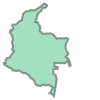

In [45]:
wkt.loads(colombia.take(1)[0].wkt)

### Venezuela

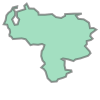

In [46]:
wkt.loads(venezuela.take(1)[0].wkt)

### Guyana

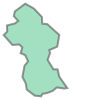

In [47]:
wkt.loads(guyana.take(1)[0].wkt)

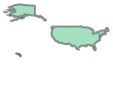

In [48]:
wkt.loads(usa.take(1)[0].wkt)

## 9. Filter Offshore Marine Zones that intersect with Countries (Mexico, Colombia, Venezuela, Guyana, USA) Boundaries

In [49]:
#load libraries pyspark
from pyspark.sql.types import *
from pyspark.sql.functions import udf

### Mexico

In [50]:
# User defined funtion for filtering region of interset
intersection_udf_mexico = udf(lambda row: True if mexico_boundary.intersects(wkt.loads(row)) else False, BooleanType())

In [51]:
#Mexico offshore marine zones
df_mexico = oz_spark_df.filter(intersection_udf_mexico(oz_spark_df["wkt"]))
pdf_mexico = df_mexico.toPandas() #convert to pandas datarframe
pdf_mexico #print out the mexico items from dataset

ID  WFO       LON       LAT  \
0  AMZ011  NH2 -81.74130  18.75795   
1  GMZ025  NH2 -93.95211  21.57751   
2  GMZ017  NH2 -93.95211  21.57751   
3  GMZ023  NH2 -93.95211  21.57751   

                                            LOCATION  \
0  from 18N-22N west of 85W to Yucatan Peninsula ...   
1                       south of 22N between 87W-94W   
2                        between 22N-26N west of 94W   
3                           south of 22N west of 94W   

                                                NAME  \
0  Caribbean Nof 18N W of 85W including Yucatan B...   
1          E Bay of Campeche including Campeche Bank   
2            W Central Gulf from 22N to 26N W of 94W   
3                          SW Gulf S of 22N W of 94W   

                                                 wkt  
0  POLYGON ((-85.0035124029999452 21.654186627000...  
1  POLYGON ((-87.0053766059999703 22.014180185000...  
2  POLYGON ((-93.9921787359999712 26.006293284000...  
3  POLYGON ((-93.9995355959999870 22.011966694000...

In [52]:
geometry = pdf_mexico['wkt'].map(wkt.loads) #load geometry from dataset
crs = {'init': 'epsg:4326'} #use crs from world map
gdf_mexico = gpd.GeoDataFrame(pdf_mexico, crs=crs, geometry=geometry) #create geometry dataframe from mexico
gdf_mexico #print out geo dataframe 

ID  WFO       LON       LAT  \
0  AMZ011  NH2 -81.74130  18.75795   
1  GMZ025  NH2 -93.95211  21.57751   
2  GMZ017  NH2 -93.95211  21.57751   
3  GMZ023  NH2 -93.95211  21.57751   

                                            LOCATION  \
0  from 18N-22N west of 85W to Yucatan Peninsula ...   
1                       south of 22N between 87W-94W   
2                        between 22N-26N west of 94W   
3                           south of 22N west of 94W   

                                                NAME  \
0  Caribbean Nof 18N W of 85W including Yucatan B...   
1          E Bay of Campeche including Campeche Bank   
2            W Central Gulf from 22N to 26N W of 94W   
3                          SW Gulf S of 22N W of 94W   

                                                 wkt  \
0  POLYGON ((-85.0035124029999452 21.654186627000...   
1  POLYGON ((-87.0053766059999703 22.014180185000...   
2  POLYGON ((-93.9921787359999712 26.006293284000...   
3  POLYGON ((-93.9995355959999870 22.011966694000...   

                                            geometry  
0  POLYGON ((-85.00351240299995 21.65418662700006...  
1  POLYGON ((-87.00537660599997 22.01418018500004...  
2  POLYGON ((-93.99217873599997 26.00629328400004...  
3  POLYGON ((-93.99953559599999 22.01196669400002...

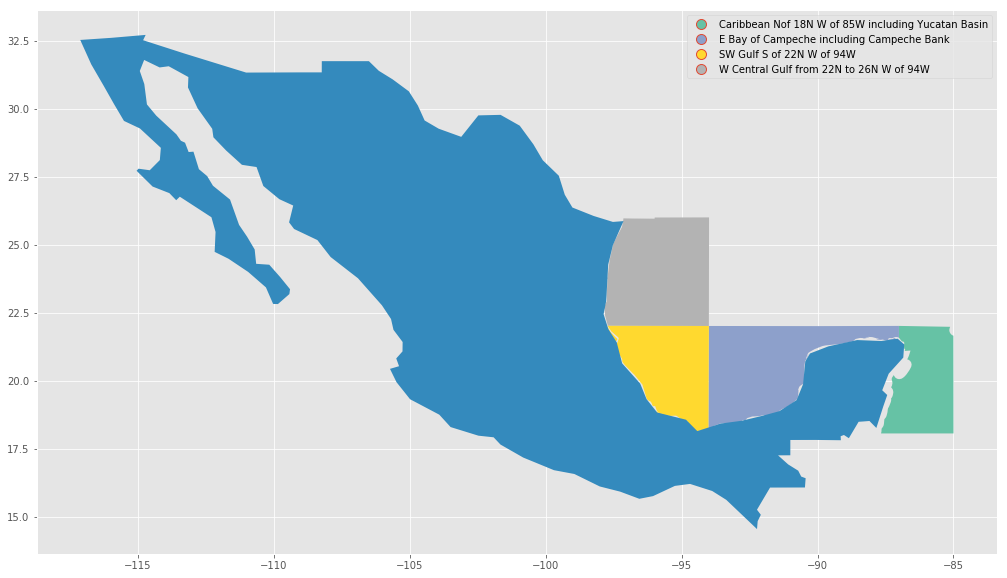

In [53]:
# Set the region
world[world['name']=='Mexico'].plot(ax=gdf_mexico.plot(cmap='Set2',column="NAME",categorical=True, legend=True,alpha=1,figsize=(20, 10)),alpha=1)
plt.show() #display the map with "NAME" legend

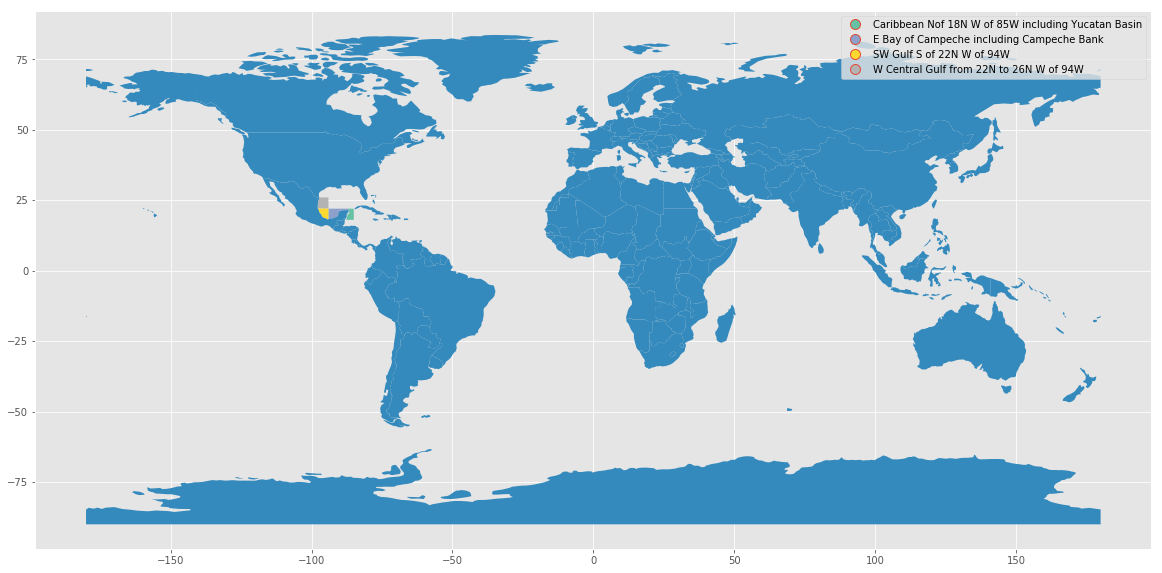

In [54]:
# Show map in the world maps
world.plot(ax=gdf_mexico.plot(cmap='Set2',column="NAME",categorical=True, legend=True, alpha=1,figsize=(20, 10))\
           ,alpha=1)
plt.show() #display the map mexico in the world map

In [55]:
cents_mex = gdf_mexico.centroid
cents_mex.head()

0    POINT (-86.08280616483469 19.86819710388435)
1    POINT (-91.82728491960776 20.53269578675714)
2     POINT (-95.80729836582793 23.9447096598724)
3    POINT (-95.43782644746898 20.46647613648946)
dtype: object

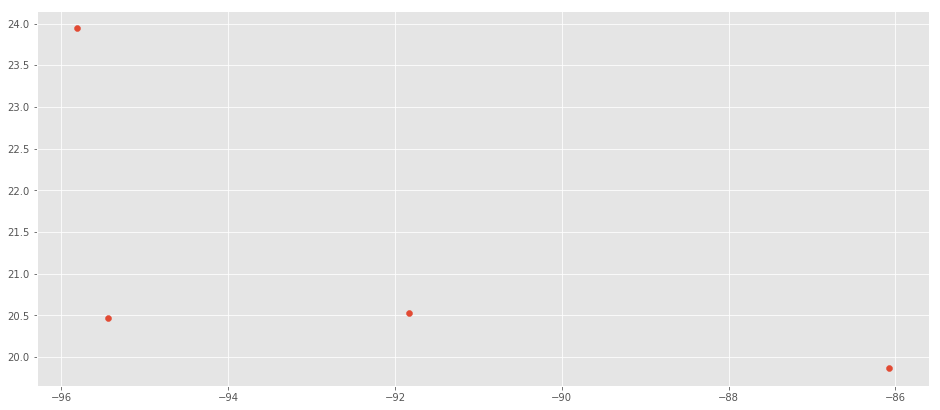

In [56]:
cents_mex.plot(figsize=(16, 8))

In [57]:
#get the statistical information from mexico
gdf_mexico.describe()

LON       LAT
count   4.000000   4.00000
mean  -90.899408  20.87262
std     6.105405   1.40978
min   -93.952110  18.75795
25%   -93.952110  20.87262
50%   -93.952110  21.57751
75%   -90.899407  21.57751
max   -81.741300  21.57751

### Colombia

In [58]:
# User defined funtion for filtering region of interset
intersection_udf_colombia = udf(lambda row: True if colombia_boundary.intersects(wkt.loads(row))
                       else False, BooleanType())

In [59]:
df_colombia = oz_spark_df.filter(intersection_udf_colombia(oz_spark_df["wkt"]))
pdf_colombia = df_colombia.toPandas() #convert to pandas dataframe
pdf_colombia #print out the colombia dataset

ID  WFO       LON       LAT  \
0  AMZ039  NH2 -79.34953  11.83763   

                                       LOCATION  \
0  south of 11N between Colombia and Costa Rica   

                                                NAME  \
0  SW Caribbean S of 11N including the approaches...   

                                                 wkt  
0  POLYGON ((-80.0132461609999837 10.989629904000...

In [60]:
geometry = pdf_colombia['wkt'].map(wkt.loads) #loads wkt colombia
crs = {'init': 'epsg:4326'} #use the wrold crs
gdf_colombia = gpd.GeoDataFrame(pdf_colombia, crs=crs, geometry=geometry) #create geometry dataframe from colombia
gdf_colombia #print out colombia geodataframe 

ID  WFO       LON       LAT  \
0  AMZ039  NH2 -79.34953  11.83763   

                                       LOCATION  \
0  south of 11N between Colombia and Costa Rica   

                                                NAME  \
0  SW Caribbean S of 11N including the approaches...   

                                                 wkt  \
0  POLYGON ((-80.0132461609999837 10.989629904000...   

                                            geometry  
0  POLYGON ((-80.01324616099998 10.98962990400003...

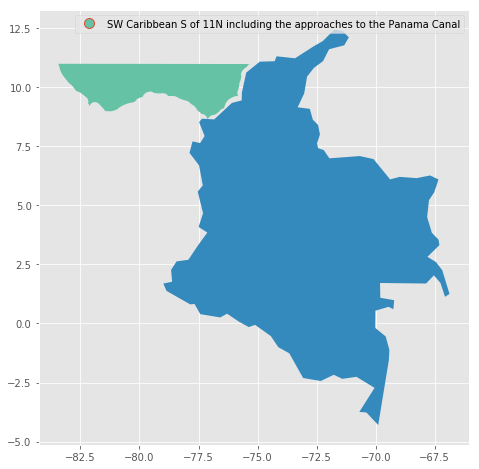

In [61]:
#set the region
world[world['name']=='Colombia'].plot(ax=gdf_colombia.plot(cmap='Set2',column="NAME", categorical=True, legend=True,alpha=1,figsize=(16, 8)),alpha=1)
plt.show() #display the map

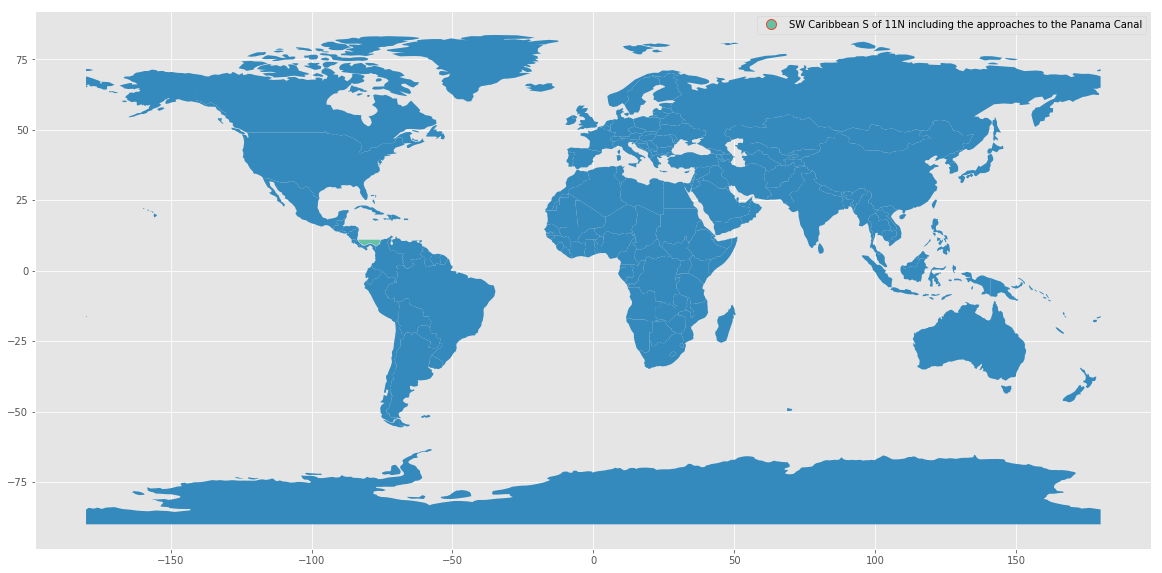

In [62]:
# Show the region in world maps
world.plot(ax=gdf_colombia.plot(cmap='Set2',column="NAME", categorical=True, legend=True,alpha=1,figsize=(20, 10)),alpha=1)
plt.show()

In [63]:
cents_col = gdf_colombia.centroid
cents_col.head()

0    POINT (-79.29540714092393 10.17066821898626)
dtype: object

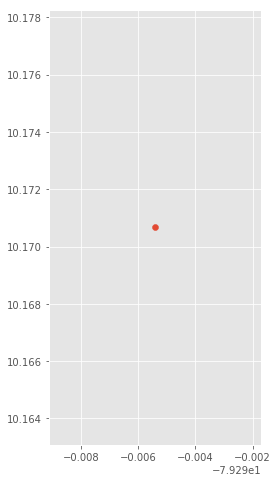

In [64]:
cents_col.plot(figsize=(16, 8))

In [65]:
#get the statistical information from colombia geodataframe
gdf_colombia.describe()

LON       LAT
count   1.00000   1.00000
mean  -79.34953  11.83763
std         NaN       NaN
min   -79.34953  11.83763
25%   -79.34953  11.83763
50%   -79.34953  11.83763
75%   -79.34953  11.83763
max   -79.34953  11.83763

### Venezuela

In [66]:
# User defined funtion for filtering region of interset
intersection_udf_venezuela = udf(lambda row: True if venezuela_boundary.intersects(wkt.loads(row))
                                 else False, BooleanType())

In [67]:
df_venezuela = oz_spark_df.filter(intersection_udf_venezuela(oz_spark_df["wkt"]))
pdf_venezuela = df_venezuela.toPandas()
pdf_venezuela

ID  WFO       LON       LAT                      LOCATION  \
0  AMZ037  NH2 -59.99007  14.44086   from 7N-15N between 55W-60W   
1  AMZ035  NH2 -59.99007  14.44086  south of 15N between 60W-64W   
2  AMZ033  NH2 -68.13905  15.13334  south of 15N between 64W-72W   

                                                NAME  \
0  Tropical N Atlantic from 7N and 15N between 55...   
1  Offshore Waters Windward Islands including Tri...   
2  Caribbean S of 15N between 64W and 72W includi...   

                                                 wkt  
0  POLYGON ((-54.9801489519999791 15.002949367000...  
1  POLYGON ((-64.0074824779999858 15.031426411000...  
2  MULTIPOLYGON (((-64.0074824779999858 15.031426...

In [68]:
geometry = pdf_venezuela['wkt'].map(wkt.loads)
crs = {'init': 'epsg:4326'}
gdf_venezuela = gpd.GeoDataFrame(pdf_venezuela, crs=crs, geometry=geometry)
gdf_venezuela

ID  WFO       LON       LAT                      LOCATION  \
0  AMZ037  NH2 -59.99007  14.44086   from 7N-15N between 55W-60W   
1  AMZ035  NH2 -59.99007  14.44086  south of 15N between 60W-64W   
2  AMZ033  NH2 -68.13905  15.13334  south of 15N between 64W-72W   

                                                NAME  \
0  Tropical N Atlantic from 7N and 15N between 55...   
1  Offshore Waters Windward Islands including Tri...   
2  Caribbean S of 15N between 64W and 72W includi...   

                                                 wkt  \
0  POLYGON ((-54.9801489519999791 15.002949367000...   
1  POLYGON ((-64.0074824779999858 15.031426411000...   
2  MULTIPOLYGON (((-64.0074824779999858 15.031426...   

                                            geometry  
0  POLYGON ((-54.98014895199998 15.00294936700004...  
1  POLYGON ((-64.00748247799999 15.03142641100004...  
2  (POLYGON ((-64.00748247799999 15.0314264110000...

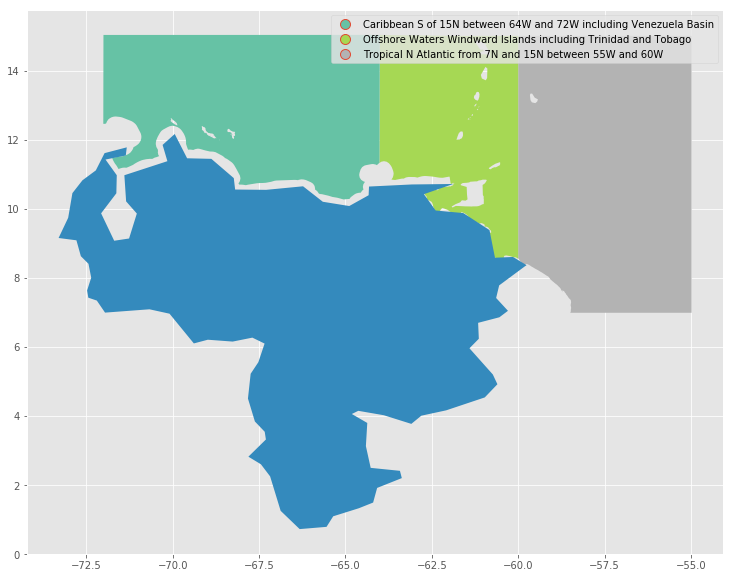

In [69]:
# Set the region of interest color to red
world[world['name']=='Venezuela'].plot(ax=gdf_venezuela.plot(cmap='Set2',column="NAME",categorical=True, legend=True, alpha=1, figsize=(20, 10)),alpha=1)
plt.show()

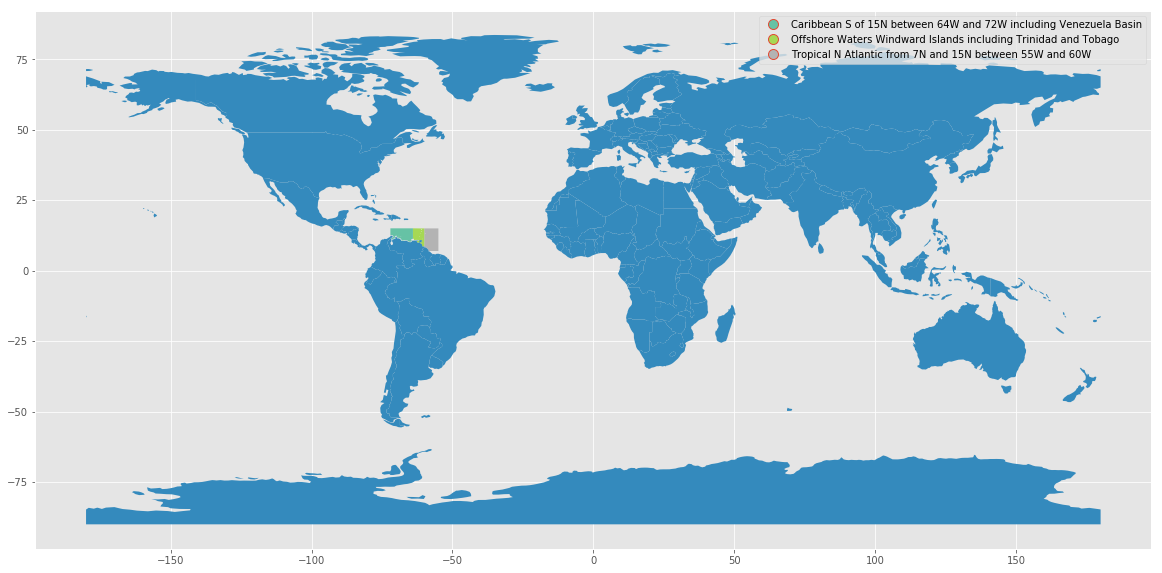

In [70]:
# Show the region in world map
world.plot(ax=gdf_venezuela.plot(cmap='Set2',column="NAME", categorical=True, legend=True, alpha=1, figsize=(20, 10)),alpha=1)
plt.show()

In [71]:
cents_ven = gdf_venezuela.centroid
cents_ven.head()

0    POINT (-57.40995459052026 11.13530316095404)
1    POINT (-61.82075224112025 12.44941461164314)
2    POINT (-67.64675528958652 13.09112574687467)
dtype: object

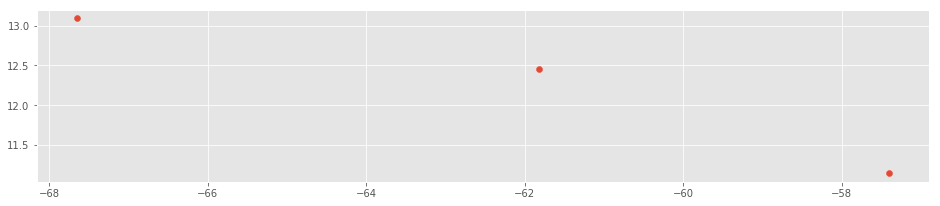

In [72]:
cents_ven.plot(figsize=(16, 8))

In [73]:
#get the statistical information from venezuela geodataframe
gdf_venezuela.describe()

LON        LAT
count   3.000000   3.000000
mean  -62.706397  14.671687
std     4.704816   0.399804
min   -68.139050  14.440860
25%   -64.064560  14.440860
50%   -59.990070  14.440860
75%   -59.990070  14.787100
max   -59.990070  15.133340

### Guyana

In [74]:
intersection_udf_guyana = udf(lambda row: True if guyana_boundary.intersects(wkt.loads(row))
                              else False, BooleanType())

In [75]:
df_guyana = oz_spark_df.filter(intersection_udf_guyana(oz_spark_df["wkt"]))
pdf_guyana = df_guyana.toPandas()
pdf_guyana

ID  WFO       LON       LAT                     LOCATION  \
0  AMZ037  NH2 -59.99007  14.44086  from 7N-15N between 55W-60W   

                                                NAME  \
0  Tropical N Atlantic from 7N and 15N between 55...   

                                                 wkt  
0  POLYGON ((-54.9801489519999791 15.002949367000...

In [76]:
geometry = pdf_guyana['wkt'].map(wkt.loads)
crs = {'init': 'epsg:4326'}
gdf_guyana = gpd.GeoDataFrame(pdf_guyana, crs=crs, geometry=geometry)
gdf_guyana

ID  WFO       LON       LAT                     LOCATION  \
0  AMZ037  NH2 -59.99007  14.44086  from 7N-15N between 55W-60W   

                                                NAME  \
0  Tropical N Atlantic from 7N and 15N between 55...   

                                                 wkt  \
0  POLYGON ((-54.9801489519999791 15.002949367000...   

                                            geometry  
0  POLYGON ((-54.98014895199998 15.00294936700004...

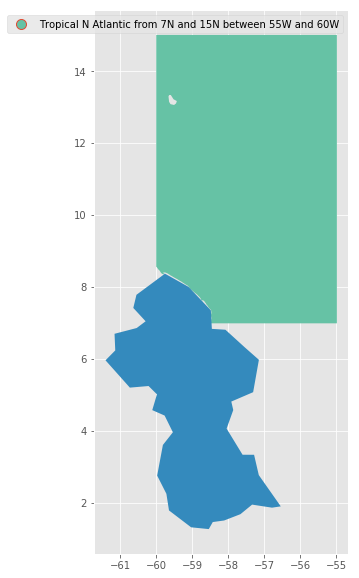

In [77]:
# Set the region
world[world['name']=='Guyana'].plot(ax=gdf_guyana.plot(cmap='Set2',column="NAME",categorical=True, legend=True,alpha=1,figsize=(20, 10)), alpha=1)
plt.show()

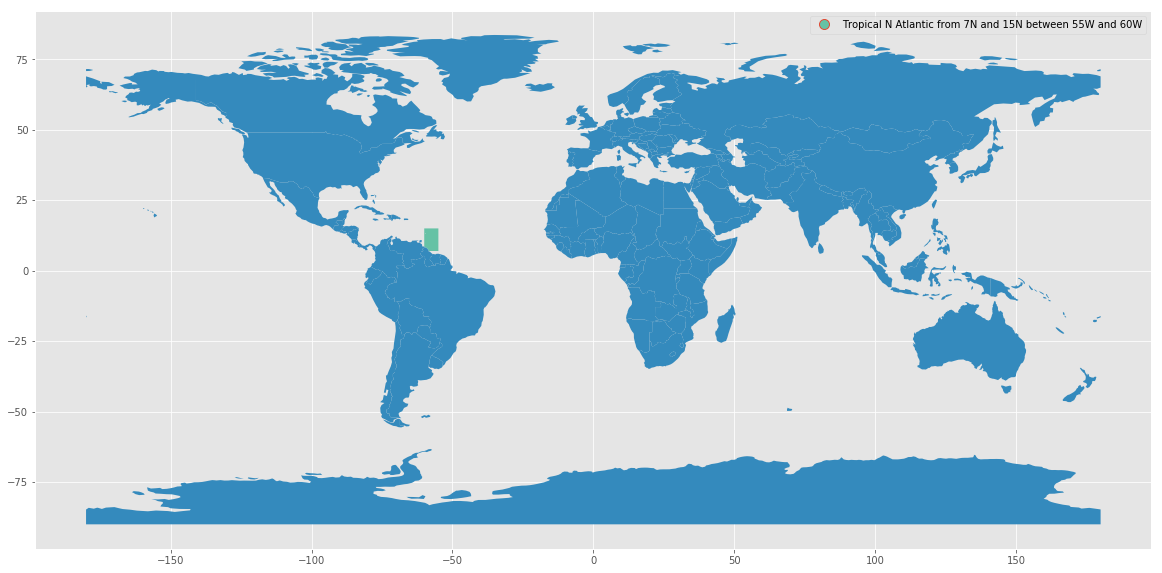

In [78]:
# Show the region in world maps
world.plot(ax=gdf_guyana.plot(cmap='Set2',column="NAME", categorical=True, legend=True, alpha=1,figsize=(20, 10)), alpha=1)
plt.show()

In [79]:
cents_guy = gdf_guyana.centroid
cents_guy.head()

0    POINT (-57.40995459052026 11.13530316095404)
dtype: object

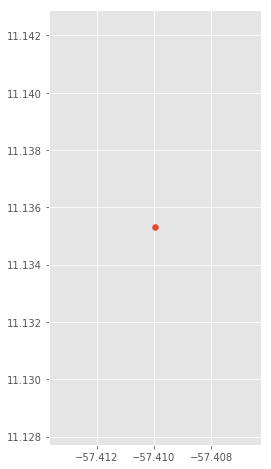

In [80]:
cents_guy.plot(figsize=(16, 8))

In [81]:
#get statistical information from guyana geodataframe
gdf_guyana.describe()

LON       LAT
count   1.00000   1.00000
mean  -59.99007  14.44086
std         NaN       NaN
min   -59.99007  14.44086
25%   -59.99007  14.44086
50%   -59.99007  14.44086
75%   -59.99007  14.44086
max   -59.99007  14.44086

### United States of America (USA)

In [82]:
intersection_udf_usa = udf(lambda row: True if usa_boundary.intersects(wkt.loads(row))
                              else False, BooleanType())

In [83]:
df_usa = oz_spark_df.filter(intersection_udf_usa(oz_spark_df["wkt"]))
pdf_usa = df_usa.toPandas()
pdf_usa

ID  WFO       LON       LAT                     LOCATION  \
0  GMZ017  NH2 -93.95211  21.57751  between 22N-26N west of 94W   

                                      NAME  \
0  W Central Gulf from 22N to 26N W of 94W   

                                                 wkt  
0  POLYGON ((-93.9921787359999712 26.006293284000...

In [84]:
geometry = pdf_usa['wkt'].map(wkt.loads)
crs = {'init': 'epsg:4326'}
gdf_usa = gpd.GeoDataFrame(pdf_usa, crs=crs, geometry=geometry)
gdf_usa

ID  WFO       LON       LAT                     LOCATION  \
0  GMZ017  NH2 -93.95211  21.57751  between 22N-26N west of 94W   

                                      NAME  \
0  W Central Gulf from 22N to 26N W of 94W   

                                                 wkt  \
0  POLYGON ((-93.9921787359999712 26.006293284000...   

                                            geometry  
0  POLYGON ((-93.99217873599997 26.00629328400004...

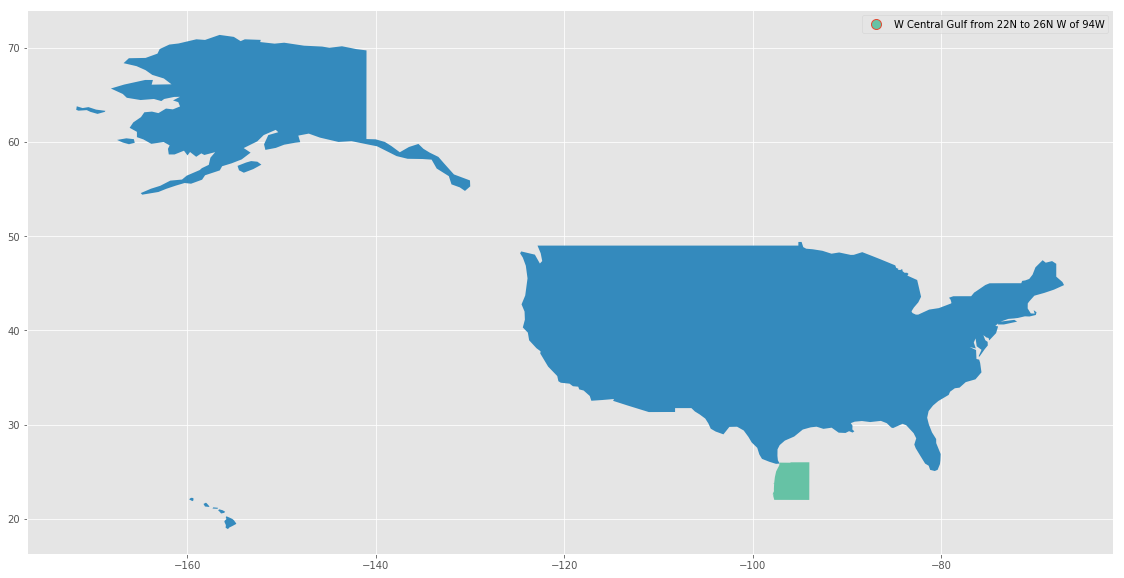

In [85]:
# Set the region
world[world['name']=='United States'].plot(ax=gdf_usa.plot(cmap='Set2',column="NAME", categorical=True,legend=True, alpha=1,figsize=(20, 10)),alpha=1)
plt.show()

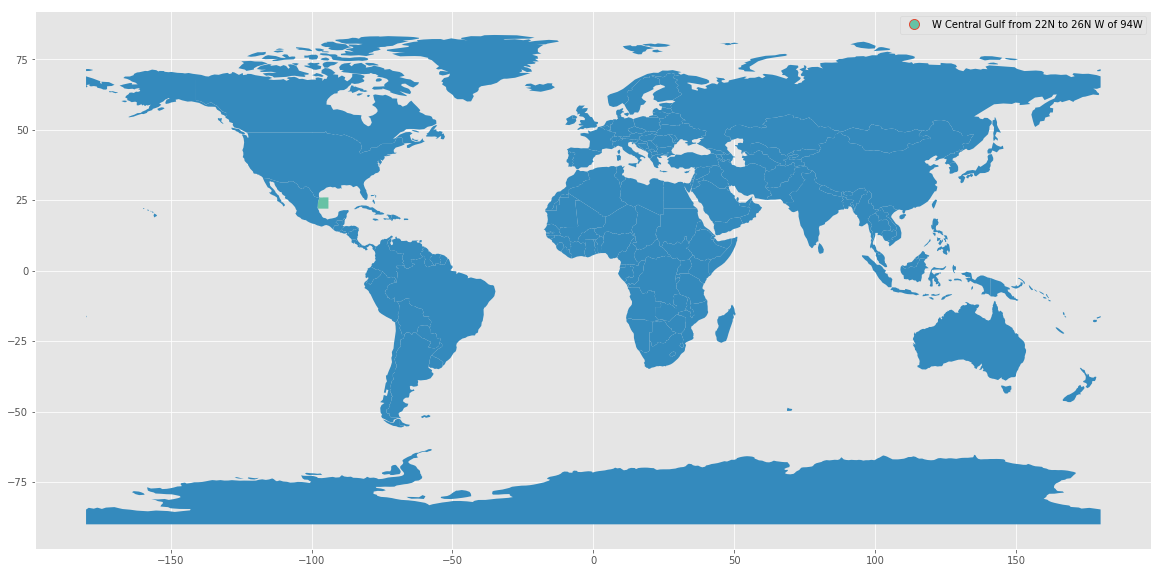

In [86]:
# Show the region in world maps
world.plot(ax=gdf_usa.plot(cmap='Set2',column="NAME", categorical=True, legend=True, alpha=1,figsize=(20, 10)),alpha=1)
plt.show()

In [87]:
cents_usa = gdf_usa.centroid
cents_usa.head()

0    POINT (-95.80729836582793 23.9447096598724)
dtype: object

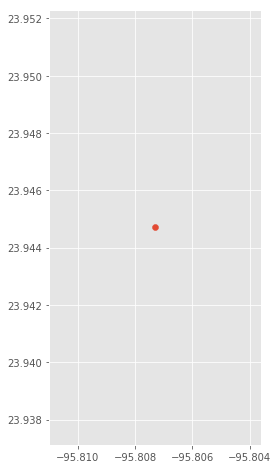

In [88]:
cents_usa.plot(figsize=(16, 8))

In [89]:
#get the statistical information from usa geodataframe
gdf_usa.describe()

LON       LAT
count   1.00000   1.00000
mean  -93.95211  21.57751
std         NaN       NaN
min   -93.95211  21.57751
25%   -93.95211  21.57751
50%   -93.95211  21.57751
75%   -93.95211  21.57751
max   -93.95211  21.57751

## 10. Coastal Marine Zone from boundaries

In [90]:
#11. 
intersection_udf_usa = udf(lambda row: True if usa_boundary.intersects(wkt.loads(row))
                              else False, BooleanType())
mz_df_usa = mz_spark_df.filter(intersection_udf_usa(mz_spark_df["wkt"]))
mz_pdf_usa = mz_df_usa.toPandas()
mz_pdf_usa

ID  WFO GL_WFO                                               NAME  \
0    PHZ113  HFO   None                                      Kauai Channel   
1    PHZ112  HFO   None                               Kauai Leeward Waters   
2    GMZ155  BRO   None  Coastal waters from Baffin Bay to Port Mansfie...   
3    GMZ657  MFL   None  Coastal waters from East Cape Sable to Chokolo...   
4    GMZ656  MFL   None  Coastal waters from Chokoloskee to Bonita Beac...   
5    GMZ350  HGX   None  Coastal waters from Freeport to Matagorda Ship...   
6    AMZ651  MFL   None  Coastal waters from Deerfield Beach to Ocean R...   
7    AMZ550  MLB   None  Flagler Beach to Volusia-Brevard County Line 0...   
8    GMZ450  LCH   None  Coastal waters from Cameron LA to High Island ...   
9    GMZ430  LCH   None                                        Sabine Lake   
10   AMZ610  MFL   None                                    Lake Okeechobee   
11   AMZ650  MFL   None  Coastal waters from Jupiter Inlet to Deerfield...   
12   AMZ555  MLB   None           Sebastian Inlet to Jupiter Inlet 0-20 nm   
13   ANZ235  BOX   None                                 Rhode Island Sound   
14   ANZ236  BOX   None                                   Narragansett Bay   
15   PZZ530  MTR   None  San Pablo Bay, Suisun Bay, the West Delta and ...   
16   PZZ531  MTR   None          San Francisco Bay South of the Bay Bridge   
17   PHZ111  HFO   None                              Kauai Windward Waters   
18   PHZ110  HFO   None                             Kauai Northwest Waters   
19   PHZ116  HFO   None                                      Kaiwi Channel   
20   PHZ115  HFO   None                                Oahu Leeward Waters   
21   PHZ114  HFO   None                               Oahu Windward Waters   
22   PHZ118  HFO   None                         Maui County Leeward Waters   
23   PHZ120  HFO   None                                    Pailolo Channel   
24   PHZ117  HFO   None                        Maui County Windward Waters   
25   PHZ119  HFO   None                                        Maalaea Bay   
26   PHZ121  HFO   None                                 Alenuihaha Channel   
27   PHZ123  HFO   None                          Big Island Leeward Waters   
28   PHZ122  HFO   None                         Big Island Windward Waters   
29   LMZ779  LOT    LOT  Lake Michigan from Wilmette Harbor to Michigan...   
..      ...  ...    ...                                                ...   
318  GMZ632  MOB   None                                  Mississippi Sound   
319  GMZ630  MOB   None                                   North Mobile Bay   
320  GMZ655  MOB   None  Coastal waters from Okaloosa-Walton County Lin...   
321  GMZ634  MOB   None      Pensacola Bay Area including Santa Roas Sound   
322  GMZ633  MOB   None                                   Perdido Bay Area   
323  GMZ650  MOB   None  Coastal waters from Pensacola FL to Pascagoula...   
324  GMZ755  TAE   None  Coastal Waters From  Ochlockonee River to Apal...   
325  GMZ750  TAE   None  Coastal waters from Okaloosa-Walton County Lin...   
326  GMZ636  MOB   None                         Eastern Choctawhatchee Bay   
327  AMZ136  MHX   None                           Pamlico and Pungo Rivers   
328  AMZ137  MHX   None                               Neuse and Bay Rivers   
329  AMZ135  MHX   None                                      Pamlico Sound   
330  AMZ130  MHX   None                                    Albemarle Sound   
331  AMZ131  MHX   None                                    Alligator River   
332  ANZ633  AKQ   None                                    Currituck Sound   
333  ANZ656  AKQ   None  Coastal Waters from Cape Charles Light to Virg...   
334  ANZ634  AKQ   None  Chesapeake Bay from Little Creek VA to Cape He...   
335  ANZ539  LWX   None                     Chester River to Queenstown MD   
336  ANZ538  LWX   None          Patapsco River including Baltimore Harbor   
337  ANZ531  LWX   None  Chesap

In [91]:
geometry = mz_pdf_usa['wkt'].map(wkt.loads)
crs = {'init': 'epsg:4326'}
mz_gdf_usa = gpd.GeoDataFrame(mz_pdf_usa, crs=crs, geometry=geometry)
mz_gdf_usa

ID  WFO GL_WFO                                               NAME  \
0    PHZ113  HFO   None                                      Kauai Channel   
1    PHZ112  HFO   None                               Kauai Leeward Waters   
2    GMZ155  BRO   None  Coastal waters from Baffin Bay to Port Mansfie...   
3    GMZ657  MFL   None  Coastal waters from East Cape Sable to Chokolo...   
4    GMZ656  MFL   None  Coastal waters from Chokoloskee to Bonita Beac...   
5    GMZ350  HGX   None  Coastal waters from Freeport to Matagorda Ship...   
6    AMZ651  MFL   None  Coastal waters from Deerfield Beach to Ocean R...   
7    AMZ550  MLB   None  Flagler Beach to Volusia-Brevard County Line 0...   
8    GMZ450  LCH   None  Coastal waters from Cameron LA to High Island ...   
9    GMZ430  LCH   None                                        Sabine Lake   
10   AMZ610  MFL   None                                    Lake Okeechobee   
11   AMZ650  MFL   None  Coastal waters from Jupiter Inlet to Deerfield...   
12   AMZ555  MLB   None           Sebastian Inlet to Jupiter Inlet 0-20 nm   
13   ANZ235  BOX   None                                 Rhode Island Sound   
14   ANZ236  BOX   None                                   Narragansett Bay   
15   PZZ530  MTR   None  San Pablo Bay, Suisun Bay, the West Delta and ...   
16   PZZ531  MTR   None          San Francisco Bay South of the Bay Bridge   
17   PHZ111  HFO   None                              Kauai Windward Waters   
18   PHZ110  HFO   None                             Kauai Northwest Waters   
19   PHZ116  HFO   None                                      Kaiwi Channel   
20   PHZ115  HFO   None                                Oahu Leeward Waters   
21   PHZ114  HFO   None                               Oahu Windward Waters   
22   PHZ118  HFO   None                         Maui County Leeward Waters   
23   PHZ120  HFO   None                                    Pailolo Channel   
24   PHZ117  HFO   None                        Maui County Windward Waters   
25   PHZ119  HFO   None                                        Maalaea Bay   
26   PHZ121  HFO   None                                 Alenuihaha Channel   
27   PHZ123  HFO   None                          Big Island Leeward Waters   
28   PHZ122  HFO   None                         Big Island Windward Waters   
29   LMZ779  LOT    LOT  Lake Michigan from Wilmette Harbor to Michigan...   
..      ...  ...    ...                                                ...   
318  GMZ632  MOB   None                                  Mississippi Sound   
319  GMZ630  MOB   None                                   North Mobile Bay   
320  GMZ655  MOB   None  Coastal waters from Okaloosa-Walton County Lin...   
321  GMZ634  MOB   None      Pensacola Bay Area including Santa Roas Sound   
322  GMZ633  MOB   None                                   Perdido Bay Area   
323  GMZ650  MOB   None  Coastal waters from Pensacola FL to Pascagoula...   
324  GMZ755  TAE   None  Coastal Waters From  Ochlockonee River to Apal...   
325  GMZ750  TAE   None  Coastal waters from Okaloosa-Walton County Lin...   
326  GMZ636  MOB   None                         Eastern Choctawhatchee Bay   
327  AMZ136  MHX   None                           Pamlico and Pungo Rivers   
328  AMZ137  MHX   None                               Neuse and Bay Rivers   
329  AMZ135  MHX   None                                      Pamlico Sound   
330  AMZ130  MHX   None                                    Albemarle Sound   
331  AMZ131  MHX   None                                    Alligator River   
332  ANZ633  AKQ   None                                    Currituck Sound   
333  ANZ656  AKQ   None  Coastal Waters from Cape Charles Light to Virg...   
334  ANZ634  AKQ   None  Chesapeake Bay from Little Creek VA to Cape He...   
335  ANZ539  LWX   None                     Chester River to Queenstown MD   
336  ANZ538  LWX   None          Patapsco River including Baltimore Harbor   
337  ANZ531  LWX   None  Chesap

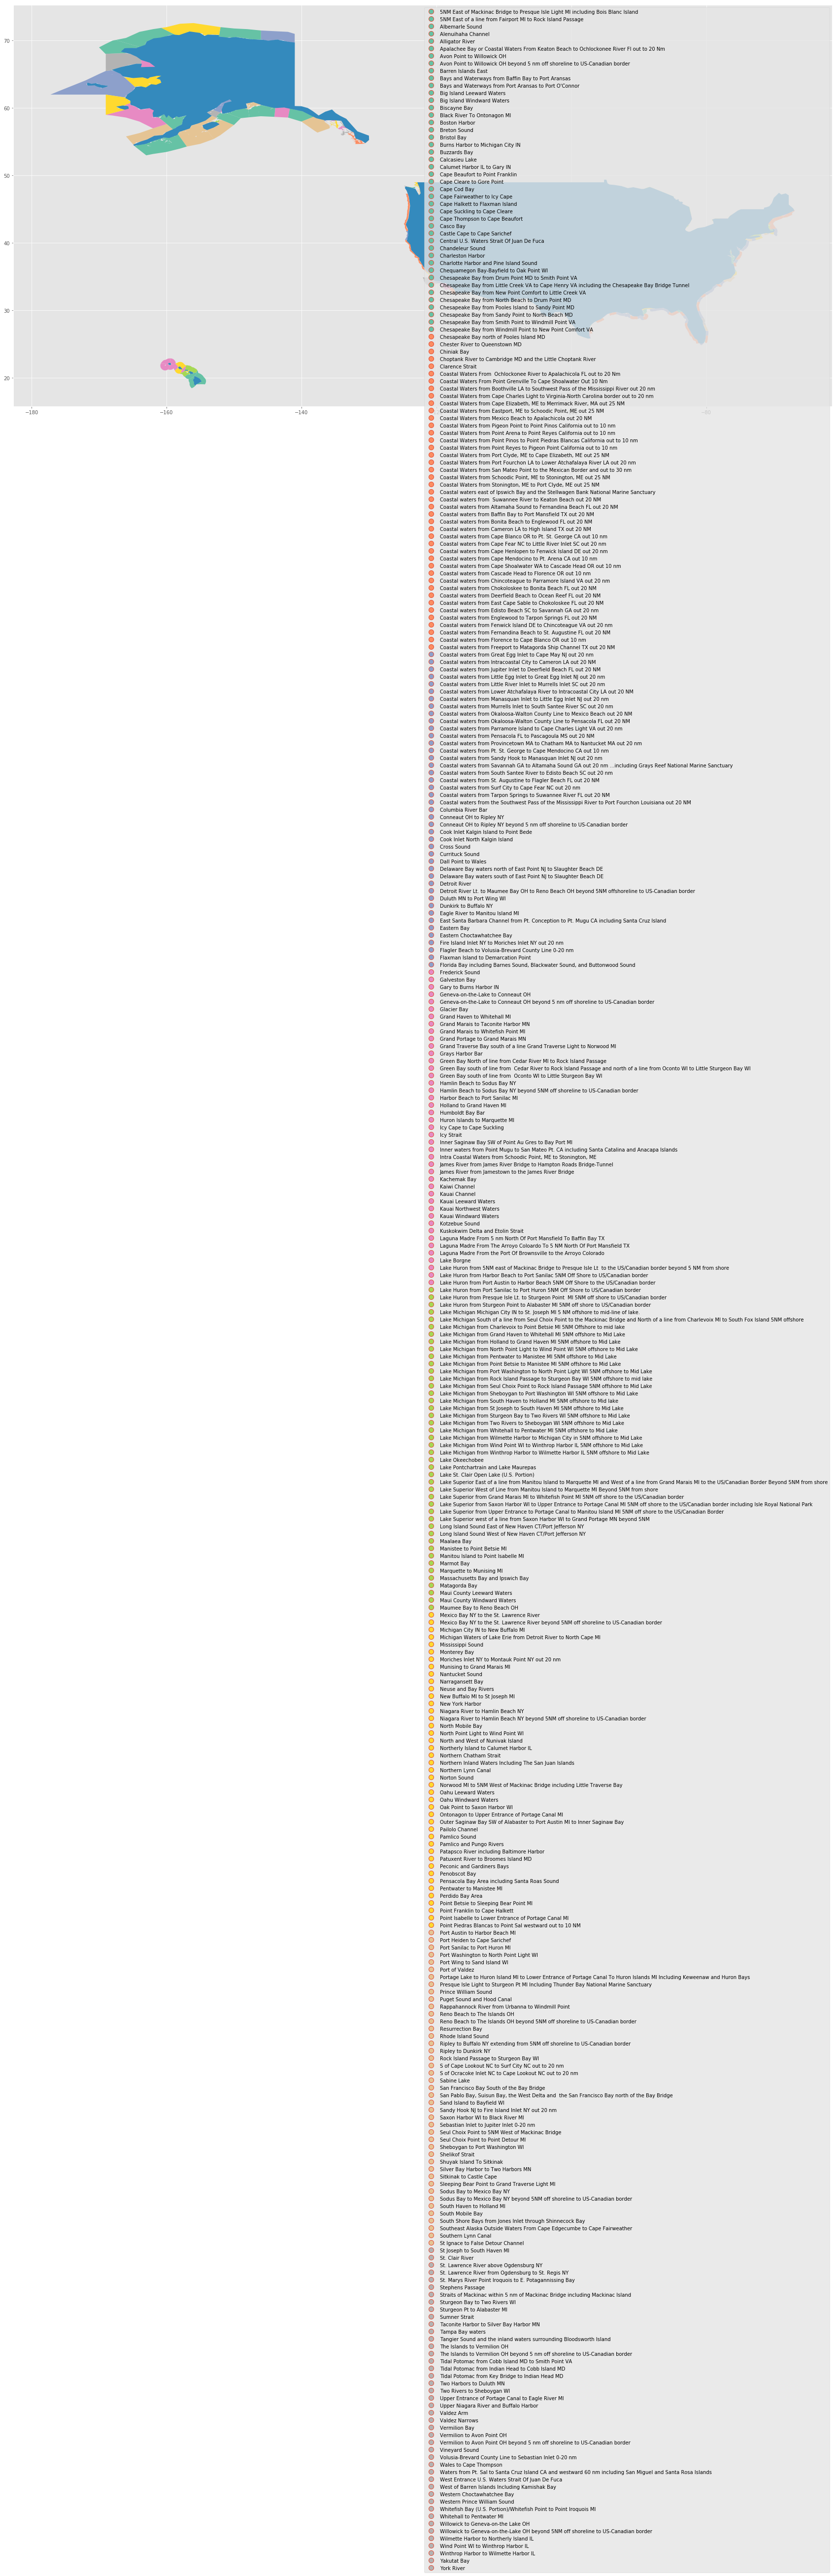

In [92]:
world[world['name']=='United States'].plot(ax=mz_gdf_usa.plot(cmap='Set2',column="NAME",categorical=True, legend=True, alpha=1,figsize=(30, 15)),alpha=1)
plt.show()

In [93]:
cents_mzusa = mz_gdf_usa.centroid
cents_mzusa.head()

0    POINT (-158.9724196326189 21.61693893242441)
1    POINT (-160.2313903386068 21.66412201886617)
2    POINT (-97.15790768346869 26.90684523917795)
3    POINT (-81.38949155095996 25.45369426599558)
4    POINT (-81.87250114898133 25.95371919321479)
dtype: object

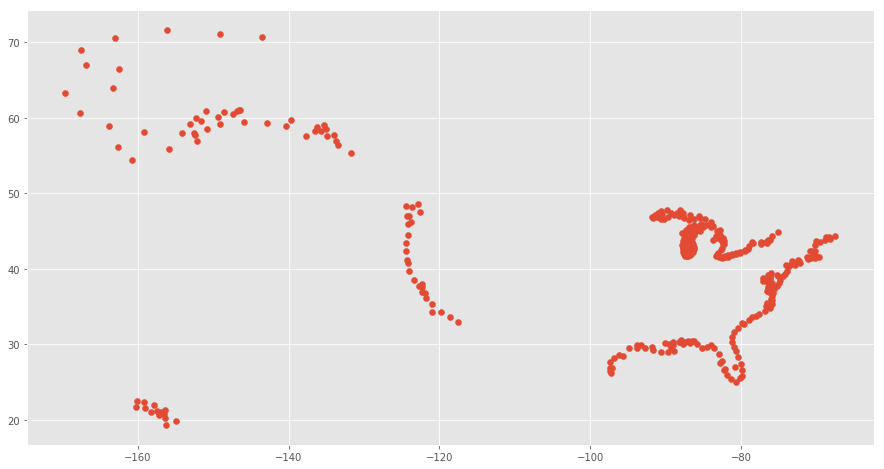

In [94]:
cents_mzusa.plot(figsize=(16, 8))

In [95]:
mz_gdf_usa.describe()

LON         LAT
count  348.000000  348.000000
mean   -97.439774   41.571437
std     27.651455   10.162223
min   -169.566785   19.317421
25%    -97.379073   35.729543
50%    -86.672993   42.211219
75%    -79.897466   45.810560
max    -67.574586   71.681322

## 12. Select Boundaries for Weather Forecast Office (WFO)

In [96]:
#print out information schema Offshore Zone
oz_spark_df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- WFO: string (nullable = true)
 |-- LON: double (nullable = true)
 |-- LAT: double (nullable = true)
 |-- LOCATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- wkt: string (nullable = true)



In [97]:
#print out offshore dataset
oz_spark_df.show()

+------+---+---------+--------+--------------------+--------------------+--------------------+
|    ID|WFO|      LON|     LAT|            LOCATION|                NAME|                 wkt|
+------+---+---------+--------+--------------------+--------------------+--------------------+
|AMZ031|NH2|-79.34953|11.83763|from 11N-15N betw...|Caribbean from 11...|POLYGON ((-72.006...|
|AMZ013|NH2| -81.7413|18.75795|north of 18N betw...|Caribbean N of 18...|POLYGON ((-82.344...|
|AMZ037|NH2|-59.99007|14.44086|from 7N-15N betwe...|Tropical N Atlant...|POLYGON ((-54.980...|
|AMZ121|NH2|-72.99113|24.81218|from 22N-27N betw...|Atlantic from 22N...|POLYGON ((-64.999...|
|AMZ011|NH2| -81.7413|18.75795|from 18N-22N west...|Caribbean Nof 18N...|POLYGON ((-85.003...|
|AMZ017|NH2| -81.7413|18.75795|south of 18N west...|    Gulf of Honduras|POLYGON ((-84.999...|
|AMZ019|NH2| -81.7413|18.75795|from 15N-18N betw...|Caribbean from 15...|POLYGON ((-80.001...|
|AMZ021|NH2| -81.7413|18.75795|from 15N-18N betw..

In [98]:
#print out count Weather forecast from offshore zone 
oz_spark_df.groupBy("WFO").count().show()

+---+-----+
|WFO|count|
+---+-----+
|NH2|   32|
|ONP|   19|
|AFC|    6|
|AFG|    3|
|HPA|    1|
|ONA|   18|
|AJK|    1|
+---+-----+



In [99]:
#createOrReplaceTempView is  Creates a temporary view using the given name. 
#The lifetime of this temporary view is tied to the SparkSession that was used to create this Dataset.
oz_spark_df.createOrReplaceTempView("offshore")

In [100]:
#HPA - Hawaii offshore zone
hpa = spark.sql("""
        SELECT wkt
        FROM offshore
        WHERE WFO='HPA'
        """)
#AJK - Alaska offshore zone
ajk = spark.sql("""
        SELECT wkt
        FROM offshore
        WHERE WFO='AJK'
        """)
#NH2 - Carribean offshore zone
nh2 = spark.sql("""
        SELECT wkt
        FROM offshore
        WHERE WFO='NH2'
        """)
#AFC - Bering sea offshore zone
afc = spark.sql("""
        SELECT wkt
        FROM offshore
        WHERE WFO='AFC'
        """)
#ONP - Oregon offshore zones USA
onp = spark.sql("""
        SELECT wkt
        FROM offshore
        WHERE WFO='ONP'
        """)
#ONA - mid-Atlantic
ona = spark.sql("""
        SELECT wkt
        FROM offshore
        WHERE WFO='ONA'
        """)
#AFG - Arctic Offshore
afg = spark.sql("""
        SELECT wkt
        FROM offshore
        WHERE WFO='AFG'
        """)

### Hawaii

<a href="http://tgftp.nws.noaa.gov/data/raw/fz/fzhw60.phfo.off.hfo.txt">OFFSHORE WATERS FORECAST for Hawaii</a>

Hawaiian offshore waters beyond 40 nautical miles out to 240
nautical miles including the portion of the Papahanaumokuakea
Marine National Monument east of French Frigate Shoals

Seas given as significant wave height, which is the average height
of the highest 1/3 of the waves. Individual waves may be more than
twice the significant wave height.

In [101]:
#show wkt item from hawaii
hpa.show()

+--------------------+
|                 wkt|
+--------------------+
|POLYGON ((-159.40...|
+--------------------+



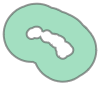

In [102]:
hpa_boundaries = wkt.loads(hpa.take(1)[0].wkt)
hpa_boundaries

In [103]:
# User defined funtion for filtering region of interset
within_udf_hpa = udf(lambda row: True if hpa_boundaries.within(wkt.loads(row))
                 else False, BooleanType())
df_hpa = oz_spark_df.filter(within_udf_hpa(oz_spark_df["wkt"]))
pdf_hpa = df_hpa.toPandas()
pdf_hpa

ID  WFO        LON       LAT LOCATION                      NAME  \
0  PHZ180  HPA -160.87879  20.57628     None  Hawaiian Offshore Waters   

                                                 wkt  
0  POLYGON ((-159.4000661719999812 26.23540199700...

In [104]:
geometry = pdf_hpa['wkt'].map(wkt.loads)
crs = {'init': 'epsg:4326'}
gdf_hpa = gpd.GeoDataFrame(pdf_hpa, crs=crs, geometry=geometry)

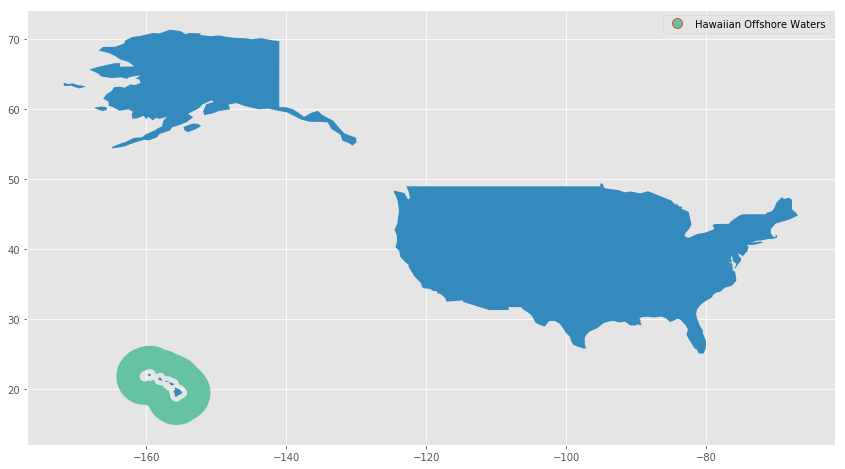

In [105]:
world[world['name']=='United States'].plot(ax=gdf_hpa.plot(cmap='Set2',column="NAME",categorical=True, legend=True, alpha=1, figsize=(16, 8)), alpha=1)
plt.show()

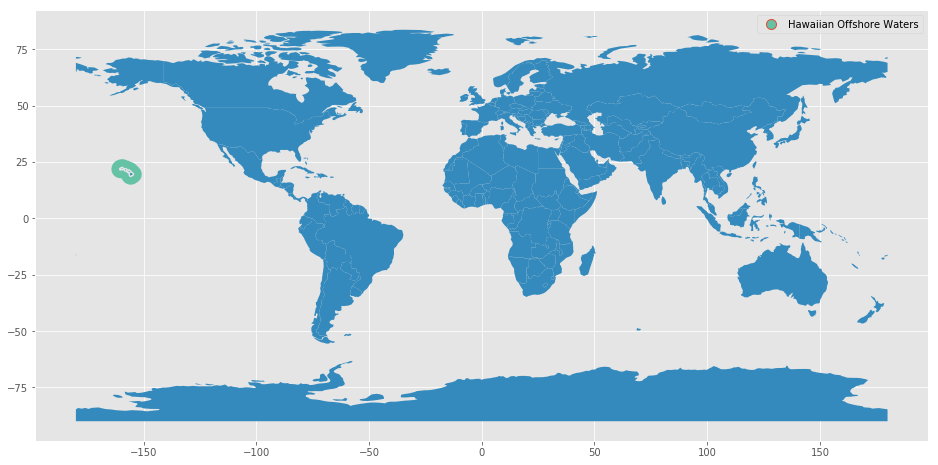

In [106]:
world.plot(ax=gdf_hpa.plot(cmap='Set2',column="NAME",categorical=True, legend=True, alpha=1, figsize=(16, 8)), alpha=1)
plt.show()

In [107]:
cents_hpa = gdf_hpa.centroid
cents_hpa.head()

0    POINT (-157.4749499782579 20.72029708980529)
dtype: object

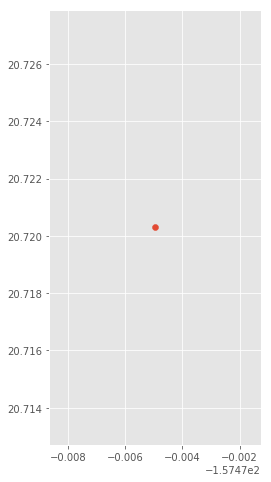

In [108]:
cents_hpa.plot(figsize=(16, 8))

In [109]:
#get the statistical information from hawaii offshore
gdf_hpa.describe()

LON       LAT
count    1.00000   1.00000
mean  -160.87879  20.57628
std          NaN       NaN
min   -160.87879  20.57628
25%   -160.87879  20.57628
50%   -160.87879  20.57628
75%   -160.87879  20.57628
max   -160.87879  20.57628

### Gulf of Alaska

<a href="http://tgftp.nws.noaa.gov/data/raw/fz/fzak67.pajk.off.ajk.txt">OFFSHORE WATERS FORECAST for Eastern Gulf Of Alaska</a>

Offshore waters forecast for Gulf of Alaska east of 144W

Wind forecasts reflect the predominant speed and direction
expected. Sea forecasts represent the average of the highest
one-third of the combined windwave and swell height.

In [110]:
#show wkt items from Gulf of Alaska
ajk.show()

+--------------------+
|                 wkt|
+--------------------+
|POLYGON ((-136.20...|
+--------------------+



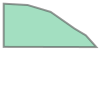

In [111]:
ajk_boundaries = wkt.loads(ajk.take(1)[0].wkt)
ajk_boundaries

In [112]:
# User defined funtion for filtering region of interset
intersection_udf_ajk = udf(lambda row: True if ajk_boundaries.intersects(wkt.loads(row))
                     else False, BooleanType())
df_ajk = oz_spark_df.filter(intersection_udf_ajk(oz_spark_df["wkt"]))
pdf_ajk = df_ajk.toPandas()
pdf_ajk

ID  WFO        LON       LAT LOCATION  \
0  PKZ310  AJK -140.06366  56.85343     None   
1  PKZ351  AFC -147.30655  57.92487     None   
2  PKZ352  AFC -149.07404  56.02611     None   

                                                NAME  \
0  Gulf of Alaska North of 55 Degrees North and E...   
1  Gulf of Alaska Offshore North of 57N and West ...   
2  Gulf of Alaska Offshore South of 57N North of ...   

                                                 wkt  
0  POLYGON ((-136.2045266229999925 55.10993149400...  
1  POLYGON ((-144.0209541689999639 58.70624147600...  
2  POLYGON ((-150.5965885299999627 57.05467993400...

In [113]:
geometry = pdf_ajk['wkt'].map(wkt.loads)
crs = {'init': 'epsg:4326'}
gdf_ajk = gpd.GeoDataFrame(pdf_ajk, crs=crs, geometry=geometry)

In [114]:
world[world['name']=='United States'].plot(ax=gdf_ajk.plot(cmap='Set2',column="NAME",categorical=True, legend=True,alpha=1, figsize=(16, 8)), alpha=1)
plt.show()

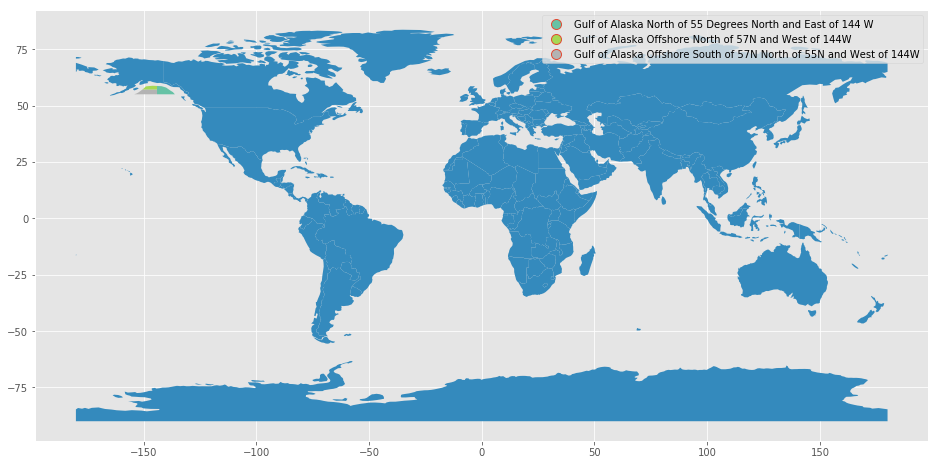

In [115]:
world.plot(ax=gdf_ajk.plot(cmap='Set2',column="NAME",categorical=True, legend=True,alpha=1, figsize=(16, 8)), alpha=1)
plt.show()

In [116]:
cents_ajk = gdf_ajk.centroid
cents_ajk.head()

0    POINT (-140.9952288385713 56.52275203955818)
1    POINT (-146.8108016817308 57.83469347136471)
2    POINT (-148.1238177234479 55.96236347965062)
dtype: object

In [117]:
cents_ajk.plot()

In [118]:
gdf_ajk.describe()

LON        LAT
count    3.000000   3.000000
mean  -145.481417  56.934803
std      4.774418   0.951992
min   -149.074040  56.026110
25%   -148.190295  56.439770
50%   -147.306550  56.853430
75%   -143.685105  57.389150
max   -140.063660  57.924870

### Caribbean / Trophical Atlantic and Carribean

<a href="http://www.nws.noaa.gov/om/marine/zone/off/offnt3cmz.htm">OFFSHORE WATERS FORECAST SYNOPSIS for the Tropical Atlantic and Caribbean</a>

Offshore Waters Forecast for the Tropical N Atlantic from 07N to
22N between 55W and 64W, the SW N Atlantic S of 31N W of 65W
including Bahamas, and the Caribbean Sea.

Seas given as significant wave height, which is the average
height of the highest 1/3 of the waves. Individual waves may be
more than twice the significant wave height.

In [119]:
nh2.show()

+--------------------+
|                 wkt|
+--------------------+
|POLYGON ((-72.006...|
|POLYGON ((-82.344...|
|POLYGON ((-54.980...|
|POLYGON ((-64.999...|
|POLYGON ((-85.003...|
|POLYGON ((-84.999...|
|POLYGON ((-80.001...|
|POLYGON ((-72.898...|
|POLYGON ((-73.598...|
|POLYGON ((-80.013...|
|POLYGON ((-80.013...|
|POLYGON ((-69.844...|
|POLYGON ((-54.980...|
|POLYGON ((-70.008...|
|POLYGON ((-64.999...|
|POLYGON ((-70.021...|
|POLYGON ((-59.999...|
|POLYGON ((-64.007...|
|POLYGON ((-76.995...|
|MULTIPOLYGON (((-...|
+--------------------+
only showing top 20 rows



In [120]:
nh2_boundaries = wkt.loads(nh2.take(1)[0].wkt)
nh2_boundaries

In [121]:
# User defined funtion for filtering region of interset
intersection_udf_nh2 = udf(lambda row: True if nh2_boundaries.intersects(wkt.loads(row))
                     else False, BooleanType())
df_nh2 = oz_spark_df.filter(intersection_udf_nh2(oz_spark_df["wkt"]))
pdf_nh2 = df_nh2.toPandas()
pdf_nh2

ID  WFO       LON       LAT  \
0  AMZ031  NH2 -79.34953  11.83763   
1  AMZ019  NH2 -81.74130  18.75795   
2  AMZ021  NH2 -81.74130  18.75795   
3  AMZ039  NH2 -79.34953  11.83763   
4  AMZ029  NH2 -79.34953  11.83763   
5  AMZ023  NH2 -68.13905  15.13334   
6  AMZ033  NH2 -68.13905  15.13334   

                                       LOCATION  \
0                  from 11N-15N between 72W-80W   
1                  from 15N-18N between 80W-85W   
2                  from 15N-18N between 72W-80W   
3  south of 11N between Colombia and Costa Rica   
4                      from 11N-15N west of 80W   
5                  from 15N-18N between 64W-72W   
6                  south of 15N between 64W-72W   

                                                NAME  \
0  Caribbean from 11N to 15N between 72W and 80W ...   
1      Caribbean from 15N to 18N between 80W and 85W   
2      Caribbean from 15N to 18N between 72W and 80W   
3  SW Caribbean S of 11N including the approaches...   
4       W Central Caribbean from 11N to 15N W of 80W   
5             Caribbean N of 15N between 64W and 72W   
6  Caribbean S of 15N between 64W and 72W includi...   

                                                 wkt  
0  POLYGON ((-72.0060664949999705 15.030321572000...  
1  POLYGON ((-80.0013789839999845 18.050949805000...  
2  POLYGON ((-72.8987445179999440 17.942300316000...  
3  POLYGON ((-80.0132461609999837 10.989629904000...  
4  POLYGON ((-80.0132461609999837 10.989629904000...  
5  POLYGON ((-69.8445775509999862 18.265387985000...  
6  MULTIPOLYGON (((-64.0074824779999858 15.031426...

In [122]:
geometry = pdf_nh2['wkt'].map(wkt.loads)
crs = {'init': 'epsg:4326'}
gdf_nh2 = gpd.GeoDataFrame(pdf_nh2, crs=crs, geometry=geometry)

In [123]:
world[world['name']=='Mexico'].plot(ax=gdf_nh2.plot(cmap='Set2', alpha=1, column="NAME",categorical=True, legend=True,figsize=(16, 8)), alpha=1)
plt.show()

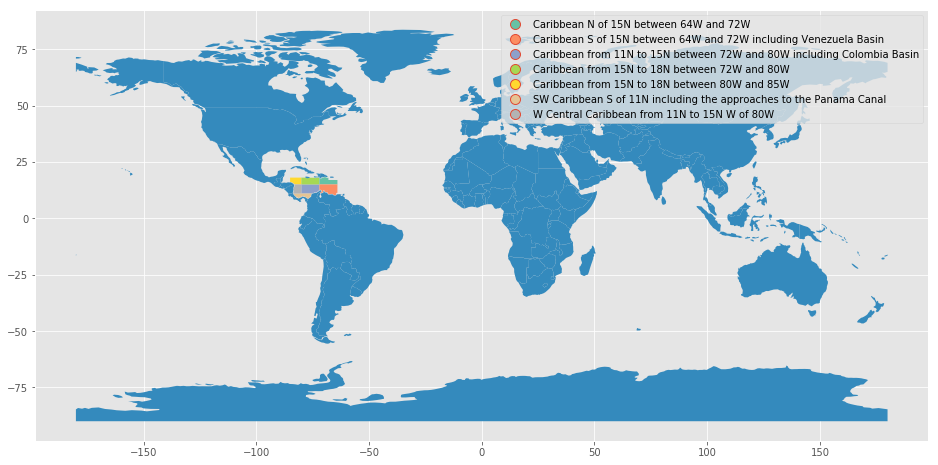

In [124]:
world.plot(ax=gdf_nh2.plot(cmap='Set2', alpha=1, column="NAME",categorical=True, legend=True,figsize=(16, 8)), alpha=1)
plt.show()

In [125]:
cents_nh2 = gdf_nh2.centroid
cents_nh2.head()

0    POINT (-76.20842221388843 13.11783970052544)
1    POINT (-82.31215791898215 16.66170920349251)
2    POINT (-76.01276209266224 16.50346767492782)
3    POINT (-79.29540714092393 10.17066821898626)
4    POINT (-81.66306982947422 12.94707087752078)
dtype: object

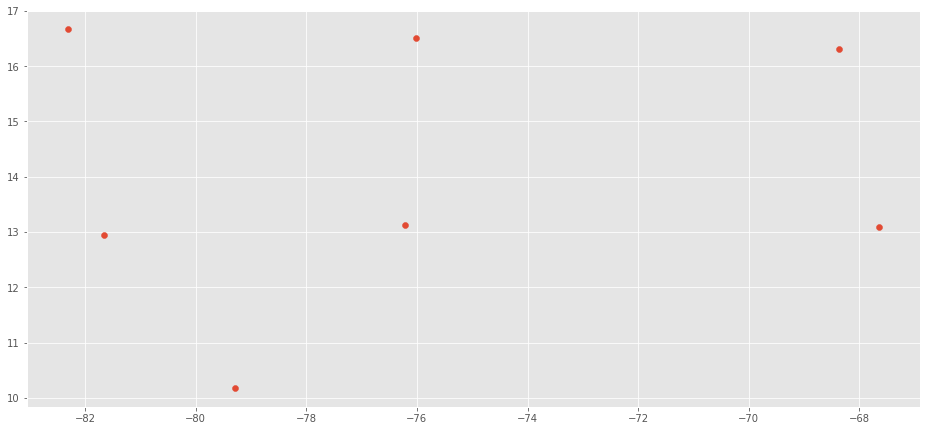

In [126]:
cents_nh2.plot(figsize=(16, 8))

In [127]:
gdf_nh2.describe()

LON        LAT
count   7.000000   7.000000
mean  -76.829899  14.756496
std     6.032565   3.105550
min   -81.741300  11.837630
25%   -80.545415  11.837630
50%   -79.349530  15.133340
75%   -73.744290  16.945645
max   -68.139050  18.757950

### Bering Sea

<a href="http://tgftp.nws.noaa.gov/data/forecasts/marine/offshore/pk/pkz499.txt">Offshore Waters Forecast for the Bering Sea</a>

Wind forecasts reflect the predominant speed and direction
expected. Sea forecasts represent an average of the highest
one-third of the combined wind wave and swell height.

In [128]:
afc.show()

+--------------------+
|                 wkt|
+--------------------+
|POLYGON ((180.000...|
|POLYGON ((-144.02...|
|POLYGON ((-150.59...|
|POLYGON ((-177.99...|
|POLYGON ((-163.99...|
|POLYGON ((-170.99...|
+--------------------+



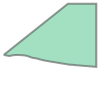

In [129]:
afc_boundaries = wkt.loads(afc.take(1)[0].wkt)
afc_boundaries

In [130]:
# User defined funtion for filtering region of interset
intersection_udf_afc = udf(lambda row: True if afc_boundaries.intersects(wkt.loads(row)) 
                           else False, BooleanType())
df_afc = oz_spark_df.filter(intersection_udf_afc(oz_spark_df["wkt"]))
pdf_afc = df_afc.toPandas()
pdf_afc

ID  WFO     LON   LAT LOCATION  \
0  PKZ411  AFC -184.25  56.1     None   

                                                NAME  \
0  Bering Sea Offshore  West of 180 and East of t...   

                                                 wkt  
0  POLYGON ((180.0000000000001137 56.044541186000...

In [131]:
geometry = pdf_afc['wkt'].map(wkt.loads)
crs = {'init': 'epsg:4326'}
gdf_afc = gpd.GeoDataFrame(pdf_afc, crs=crs, geometry=geometry)

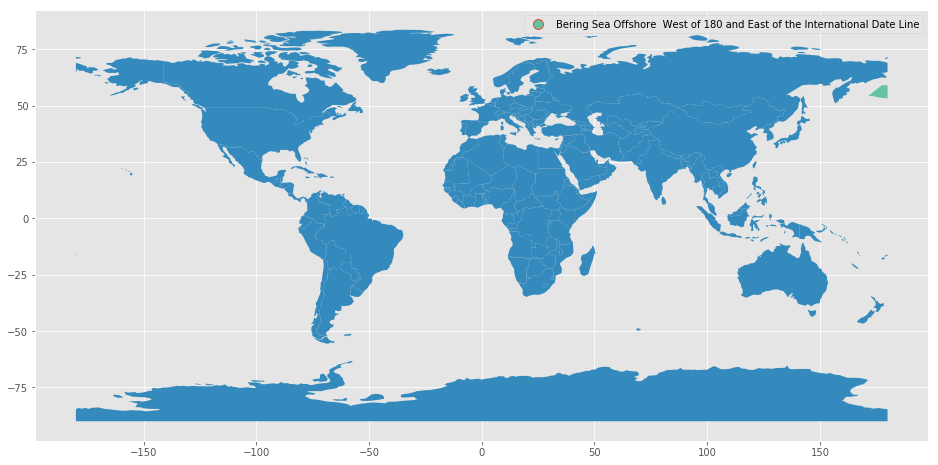

In [132]:
world.plot(ax=gdf_afc.plot(cmap='Set2',column="NAME",categorical=True, legend=True, alpha=1, figsize=(16, 8)), alpha=1)
plt.show()

In [133]:
cents_afc = gdf_afc.centroid
cents_afc.head()

0    POINT (177.0346671227725 55.87747604870662)
dtype: object

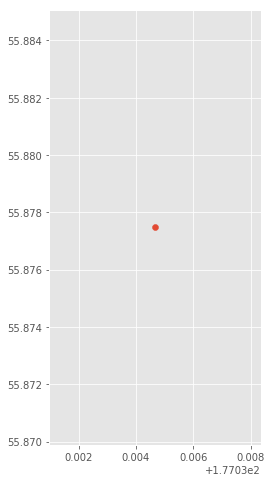

In [134]:
cents_afc.plot(figsize=(16, 8))


In [135]:
gdf_afc.describe()

LON   LAT
count    1.00   1.0
mean  -184.25  56.1
std       NaN   NaN
min   -184.25  56.1
25%   -184.25  56.1
50%   -184.25  56.1
75%   -184.25  56.1
max   -184.25  56.1

### Oregon

<a href="http://tgftp.nws.noaa.gov/data/raw/fz/fzpn25.kwbc.off.pz5.txt">OFFSHORE WATERS FORECAST for Oregon and Washington</a>

Washington and Oregon waters-
Inner waters from  60 nm to 150 nm offshore.
Outer waters from 150 nm to 250 nm offshore.

Seas given as significant wave height, which is the average
height of the highest 1/3 of the waves. Individual waves may be
more than twice the significant wave height.


In [136]:
onp.show()

+--------------------+
|                 wkt|
+--------------------+
|POLYGON ((-127.94...|
|POLYGON ((-127.32...|
|POLYGON ((-126.69...|
|POLYGON ((-124.52...|
|POLYGON ((-119.95...|
|POLYGON ((-120.90...|
|POLYGON ((-122.89...|
|POLYGON ((-122.97...|
|POLYGON ((-125.69...|
|POLYGON ((-127.03...|
|POLYGON ((-125.51...|
|POLYGON ((-130.03...|
|POLYGON ((-125.51...|
|POLYGON ((-125.79...|
|POLYGON ((-125.10...|
|POLYGON ((-125.61...|
|POLYGON ((-123.89...|
|POLYGON ((-122.89...|
|POLYGON ((-118.98...|
+--------------------+



In [137]:
onp_boundaries = wkt.loads(onp.take(1)[0].wkt)
onp_boundaries

In [138]:
# User defined funtion for filtering region of interset
intersection_udf_onp = udf(lambda row: True if onp_boundaries.intersects(wkt.loads(row)) 
                           else False, BooleanType())
df_onp = oz_spark_df.filter(intersection_udf_onp(oz_spark_df["wkt"]))
pdf_onp = df_onp.toPandas()
pdf_onp

ID  WFO        LON       LAT LOCATION  \
0  PZZ900  ONP -128.24399  46.92668     None   
1  PZZ800  ONP -128.24399  46.92668     None   
2  PZZ905  ONP -128.24399  46.92668     None   
3  PZZ805  ONP -128.24399  46.92668     None   

                                                NAME  \
0  Cape Flattery to Cape Shoalwater between 150 N...   
1  Cape Flattery to Cape Shoalwater between 60 NM...   
2  Cape Shoalwater to Cape Lookout between 150 NM...   
3  Cape Shoalwater to Cape Lookout between 60 NM ...   

                                                 wkt  
0  POLYGON ((-127.9433348509999746 48.51260424600...  
1  POLYGON ((-125.6992814129999942 46.74003600700...  
2  POLYGON ((-127.0381578009999544 45.08483482600...  
3  POLYGON ((-125.5179195269999468 45.11623887900...

In [139]:
geometry = pdf_onp['wkt'].map(wkt.loads)
crs = {'init': 'epsg:4326'}
gdf_onp = gpd.GeoDataFrame(pdf_onp, crs=crs, geometry=geometry)

In [140]:
world[world['name']=='United States'].plot(ax=gdf_onp.plot(cmap='Set2',column="NAME",categorical=True, legend=True, alpha=1, figsize=(16, 8)), alpha=1)
plt.show()

In [141]:
world.plot(ax=gdf_onp.plot(cmap='Set2',column="NAME",categorical=True, legend=True, alpha=1, figsize=(16, 8)), alpha=1)
plt.show()

In [142]:
cents_onp = gdf_onp.centroid
cents_onp.head()

0    POINT (-129.3384331514979 47.62330775265004)
1    POINT (-126.9188509680832 47.59466144429172)
2    POINT (-128.6552395394202 45.91900254805826)
3    POINT (-126.3374789816804 45.91888753525936)
dtype: object

In [143]:
cents_onp.plot(figsize=(16, 8))

In [144]:
gdf_onp.describe()

LON       LAT
count    4.00000   4.00000
mean  -128.24399  46.92668
std      0.00000   0.00000
min   -128.24399  46.92668
25%   -128.24399  46.92668
50%   -128.24399  46.92668
75%   -128.24399  46.92668
max   -128.24399  46.92668

#### Georges Bank/Mid Atlantic

<a href="http://www.nws.noaa.gov/om/marine/zone/off/offnt2mz.htm">OFFSHORE WATERS FORECAST for the Mid-Atlantic</a>

West central North Atlantic continental shelf and slope waters
beyond 20 nm to 250 nm offshore, including south of Georges Bank
from 1000 fm to 250 nm offshore.

In [145]:
ona.show()

+--------------------+
|                 wkt|
+--------------------+
|POLYGON ((-68.894...|
|POLYGON ((-69.645...|
|POLYGON ((-73.516...|
|POLYGON ((-70.276...|
|POLYGON ((-67.284...|
|POLYGON ((-67.143...|
|POLYGON ((-71.393...|
|POLYGON ((-64.994...|
|POLYGON ((-65.748...|
|POLYGON ((-69.996...|
|POLYGON ((-69.001...|
|POLYGON ((-73.935...|
|POLYGON ((-73.929...|
|POLYGON ((-74.916...|
|POLYGON ((-75.003...|
|POLYGON ((-72.282...|
|POLYGON ((-76.958...|
|POLYGON ((-76.995...|
+--------------------+



In [146]:
ona_boundaries = wkt.loads(ona.take(1)[0].wkt)
ona_boundaries

In [147]:
# User defined funtion for filtering region of interset
intersection_udf_ona = udf(lambda row: True if ona_boundaries.intersects(wkt.loads(row))
                     else False, BooleanType())
df_ona = oz_spark_df.filter(intersection_udf_ona(oz_spark_df["wkt"]))
pdf_ona = df_ona.toPandas()
pdf_ona

ID  WFO       LON       LAT LOCATION  \
0  ANZ805  ONA -67.79496  41.05695     None   
1  ANZ810  ONA -71.26536  40.21841     None   
2  ANZ800  ONA -67.79496  41.05695     None   
3  ANZ900  ONA -67.79496  41.05695     None   
4  ANZ905  ONA -69.86162  38.74287     None   

                                                NAME  \
0  Georges Bank between Cape Cod and 68W north of...   
1  South of New England between the Great South C...   
2                    Gulf of Maine to the Hague Line   
3        Georges Bank between 68W and the Hague Line   
4  East of 69W to the Hague Line between 1000 FM ...   

                                                 wkt  
0  POLYGON ((-68.8948808749999557 39.801980058000...  
1  POLYGON ((-69.6452198549999366 41.007721721000...  
2  POLYGON ((-67.2840485229999672 44.172511153000...  
3  POLYGON ((-67.1436606699999743 42.258439835000...  
4  POLYGON ((-64.9949465829999440 39.732457114000...

In [148]:
geometry = pdf_ona['wkt'].map(wkt.loads)
crs = {'init': 'epsg:4326'}
gdf_ona = gpd.GeoDataFrame(pdf_ona, crs=crs, geometry=geometry)

In [149]:
world[world['name']=='United States'].plot(ax=gdf_ona.plot(cmap='Set2',column="NAME",categorical=True, legend=True, alpha=1,figsize=(16, 8)), alpha=1)
plt.show()

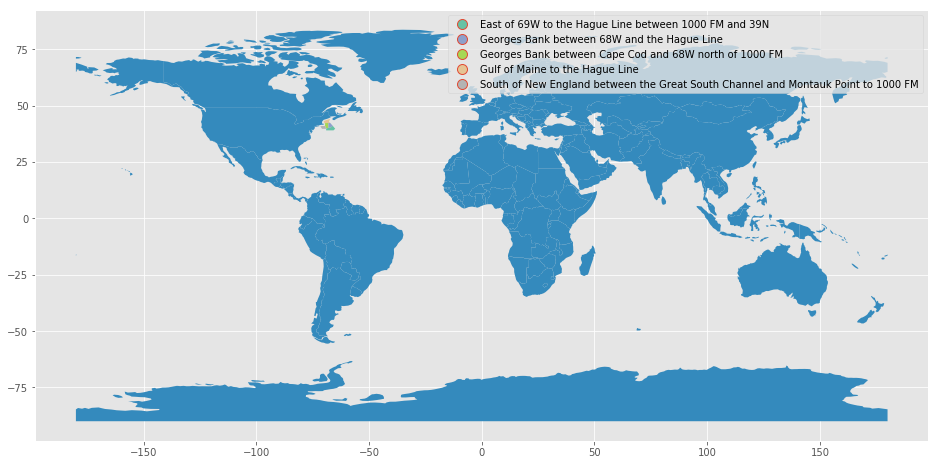

In [150]:
world.plot(ax=gdf_ona.plot(cmap='Set2',column="NAME",categorical=True, legend=True, alpha=1,figsize=(16, 8)), alpha=1)
plt.show()

In [151]:
cents_ona = gdf_ona.centroid
cents_ona.head()

0    POINT (-68.71591053380666 41.18586030139494)
1    POINT (-70.20337510685575 40.31762174187179)
2    POINT (-68.60518815282236 42.98199808202587)
3     POINT (-67.27666456821444 41.1964910602658)
4     POINT (-66.93193335839825 39.7201810964782)
dtype: object

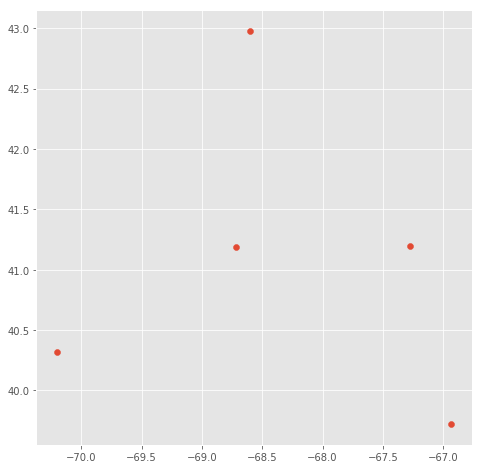

In [152]:
cents_ona.plot(figsize=(16, 8))

In [153]:
gdf_ona.describe()

LON        LAT
count   5.000000   5.000000
mean  -68.902372  40.426426
std     1.595537   1.008751
min   -71.265360  38.742870
25%   -69.861620  40.218410
50%   -67.794960  41.056950
75%   -67.794960  41.056950
max   -67.794960  41.056950

### Arctic 

<a href="http://tgftp.nws.noaa.gov/data/raw/fz/fzak69.pafg.off.afg.txt">Offshore Waters Forecast for the US Arctic Waters</a>

Sea forecasts represent an average of the highest one-third of
the combined wind wave and swell height. Individual waves may be
twice as high.

In [154]:
afg.show()

+--------------------+
|                 wkt|
+--------------------+
|POLYGON ((-141.00...|
|POLYGON ((-151.46...|
|POLYGON ((-161.92...|
+--------------------+



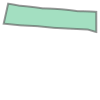

In [155]:
afg_boundaries = wkt.loads(afg.take(1)[0].wkt)
afg_boundaries

In [156]:
# User defined funtion for filtering region of interset
intersection_udf_afg = udf(lambda row: True if afg_boundaries.intersects(wkt.loads(row))
                     else False, BooleanType())
df_afg = oz_spark_df.filter(intersection_udf_afg(oz_spark_df["wkt"]))
pdf_afg = df_afg.toPandas()
pdf_afg

ID  WFO      LON     LAT LOCATION                        NAME  \
0  PKZ510  AFG -145.819  72.621     None  Eastern US Arctic Offshore   
1  PKZ505  AFG -158.049  73.283     None  Central US Arctic Offshore   

                                                 wkt  
0  POLYGON ((-141.0067875519999916 73.39924267400...  
1  POLYGON ((-151.4685634519999837 74.36708417100...

In [157]:
geometry = pdf_afg['wkt'].map(wkt.loads)
crs = {'init': 'epsg:4326'}
gdf_afg = gpd.GeoDataFrame(pdf_afg, crs=crs, geometry=geometry)

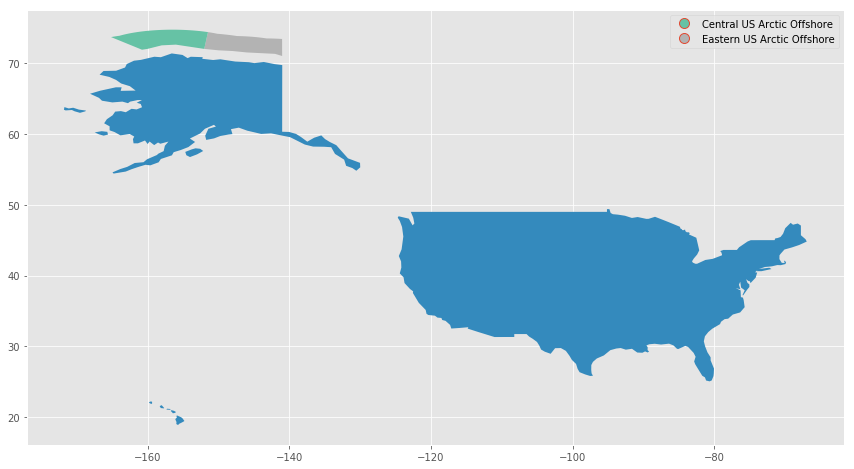

In [158]:
world[world['name']=='United States'].plot(ax=gdf_afg.plot(cmap='Set2',column="NAME",categorical=True, legend=True, alpha=1,figsize=(16, 8)), alpha=1)
plt.show()

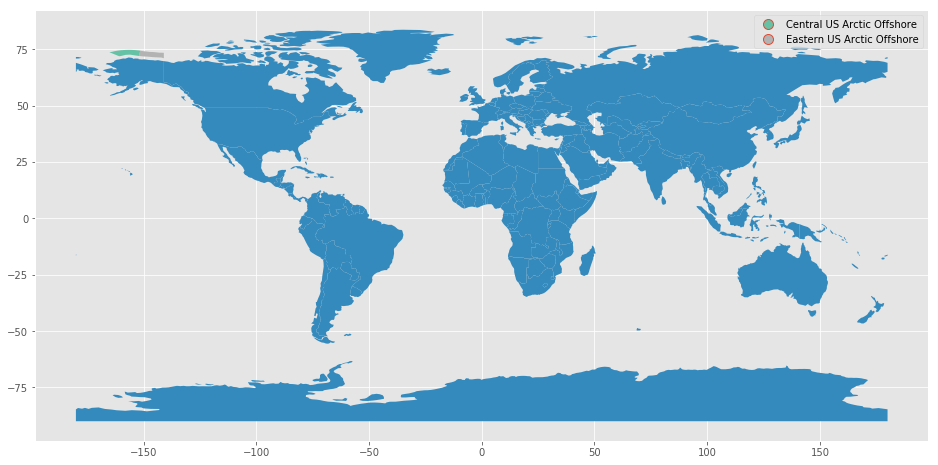

In [159]:
world.plot(ax=gdf_afg.plot(cmap='Set2',column="NAME",categorical=True, legend=True, alpha=1,figsize=(16, 8)), alpha=1)
plt.show()

In [160]:
cents_afg = gdf_afg.centroid
cents_afg.head()

0    POINT (-146.4418049262104 72.67695764644961)
1    POINT (-157.5491022306329 73.44044088386518)
dtype: object

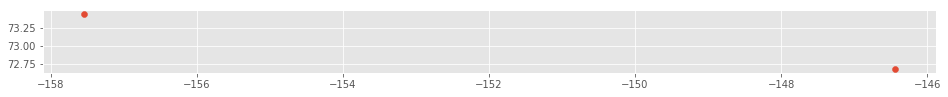

In [161]:
cents_afg.plot(figsize=(16, 8))

In [162]:
gdf_afg.describe()

LON        LAT
count    2.000000   2.000000
mean  -151.934000  72.952000
std      8.647916   0.468105
min   -158.049000  72.621000
25%   -154.991500  72.786500
50%   -151.934000  72.952000
75%   -148.876500  73.117500
max   -145.819000  73.283000